<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Reddit Insights: Understanding Uber Eats vis-a-vis DoorDash

---


# Problem Statement

We are a team of analysts from Uber Eats, attempting to find out if there is brand differentiation between our platform and Door Dash, and what are the general trends in vernacular that our Uber Eats community, both drivers and users, are using.

These will seek to inform our marketing team about how we can bring out brand forward, and also our platform/product management team on how we can improve our services.

We will be using subreddit posts to find out what words differentiate us from our competitor, and which words are most commonly used amongst the communities.

We will explore various models to find out which is the most accurate, as being able to get the highest accuracy of identifying our competitor and our own will allow us to utilise the differentiating words well (these words are able to tell us and DoorDash apart).

Caveats: Throughout this document, there would be references to DD and UE, which are the acronyms for DoorDash and Uber Eats respectively. This will be even more commonly used when labelling our data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [2]:
doordash = pd.read_csv('./door_dash_2.csv', low_memory = False)

In [3]:
ubereats = pd.read_csv('./uber_eats.csv', low_memory = False)

In [4]:
dd = doordash[['subreddit','selftext','title']]

In [5]:
ue = ubereats[['subreddit','selftext','title']]

# Exploratory Data Analysis - Data Cleaning

In [6]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20096 entries, 0 to 20095
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  20096 non-null  object
 1   selftext   12097 non-null  object
 2   title      20096 non-null  object
dtypes: object(3)
memory usage: 471.1+ KB


In [7]:
dd.head(5)

,subreddit,selftext,title
0,doordash,I wanted to start delivering but I only want t...,How do I request my town get bike delivery?
1,doordash,"Hey everyone,\n\nJust want to say how helpful ...",Newbie question about stacked orders and probl...
2,doordash,NaN,not bad for 4 deliveries i’d say? just sat at ...
3,doordash,NaN,Can't cancel Dash Pass
4,doordash,NaN,No option to cancel recurring Dash Pass paymen...


### Deleted or Removed Selftexts (DD)

There are self-texts that are deleted, and are posts that have their content deleted by the user themselves. These are expressed as [deleted] within the selftext. We want to remove these texts as they seem to be redundant, which might have led to their self-censorship. Though there might be some good information within, we would not keep these data in general.



E.g. There are posts on whether it is possible to get money for gas, or titles that outrightly say "Not a UberEats question".

We wil also remove rows where selftext information has been removed, which means they have been moderated out by the moderators, and are expressed as [removed]. These might contain information that are obsolete.


In [8]:
dd[dd["selftext"] == "[deleted]"]

,subreddit,selftext,title
717,doordash,[deleted],Whats up guys lol
2039,doordash,[deleted],"This why I always leave at the door, I'm not a..."
4220,doordash,[deleted],Trifecta of shit -- Where is a Top Dasher when...
5028,doordash,[deleted],slow dldla sndjskls
5897,doordash,[deleted],Problems with tipping
...,...,...,...
19807,doordash,[deleted],I love good door dash drivers thank you guys 🙏🏽
19816,doordash,[deleted],I think I can say this was the weirdest thing ...
19818,doordash,[deleted],"No ratings, like at all? I don’t know why"
19827,doordash,[deleted],Says I have a non delivery but when I click on...


In [9]:
dd = dd[dd["selftext"] != "[deleted]"]


In [10]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20018 entries, 0 to 20095
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  20018 non-null  object
 1   selftext   12019 non-null  object
 2   title      20018 non-null  object
dtypes: object(3)
memory usage: 625.6+ KB


In [11]:
dd[dd["selftext"] == "[removed]"]

,subreddit,selftext,title
13,doordash,[removed],WEL COME MY BLOGGER....
27,doordash,[removed],Sketchy Restaurant is a Scam to Say the Least
31,doordash,[removed],Driver delivered to a wrong address...somehow....
72,doordash,[removed],Dashin in Philly
78,doordash,[removed],I never received my tax forms
...,...,...,...
19961,doordash,[removed],Being in this sub for over a year I realized.....
19969,doordash,[removed],Posting for people who haven't seen this yet
20010,doordash,[removed],Normalize Bullying Top Dashers
20025,doordash,[removed],Does anyone know if I can use a prepaid Green ...


In [12]:
dd = dd[dd["selftext"] != "[removed]"]

In [13]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18881 entries, 0 to 20095
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  18881 non-null  object
 1   selftext   10882 non-null  object
 2   title      18881 non-null  object
dtypes: object(3)
memory usage: 590.0+ KB


### Deleted or Removed Selftexts (UE)

Similar explanation as DD's

In [14]:
ue[ue["selftext"] == "[deleted]"]

,subreddit,selftext,title
21,UberEATS,[deleted],Will this gamble be worth it?
91,UberEATS,[deleted],idk how it’s not more commonly known that if y...
674,UberEATS,[deleted],Questions to uber delivery people
2097,UberEATS,[deleted],Can I return a tip?
2478,UberEATS,[deleted],I know where you live bitch...
...,...,...,...
20018,UberEATS,[deleted],Anyone else see this?
20030,UberEATS,[deleted],A couple of reasons why you have a bad rating.
20051,UberEATS,[deleted],"Has Uber fixed the ""Press confirmed delivered ..."
20074,UberEATS,[deleted],If possible could anyone spare a few dollars i...


In [15]:
ue = ue[ue["selftext"] != "[deleted]"]

In [16]:
ue[ue["selftext"] == "[removed]"]

,subreddit,selftext,title
9,UberEATS,[removed],Fraud on my account
94,UberEATS,[removed],I am confused with uber taxes and not receivin...
100,UberEATS,[removed],Please Help!
117,UberEATS,[removed],"Given my location, would you recommend to star..."
145,UberEATS,[removed],do you have to record your miles in an app for...
...,...,...,...
20075,UberEATS,[removed],Anyone doing late night UberEats delivery?? Do...
20076,UberEATS,[removed],Today is the slowest I have seen it in the pas...
20081,UberEATS,[removed],App crashing on orders
20091,UberEATS,[removed],Anyone do Coeur d'Alene or Post Falls?


In [17]:
ue = ue[ue["selftext"] != "[removed]"]

In [18]:
ue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19147 entries, 0 to 20093
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  19147 non-null  object
 1   selftext   8582 non-null   object
 2   title      19147 non-null  object
dtypes: object(3)
memory usage: 598.3+ KB


### Null Values for SelfText (DD)

There are quite some NaN values in the self text, and might be pictures or the person did not include. 

However, we realise that the texts for the titles are still important, as they give context of the pictures or might be the entirety of the story, and therefore contain important information such as sentiments.

Some examples include: 
e.g. not bad for 4 deliveries i’d say? just sat at home until i got an order worth taking --> though we cannot see the picture, we can understand that there seems to be a good tip coming through for this DD person.
e.g. Can't cancel Dash Pass -->  there has been issues of inability to cancel Dash Pass during this time period

Therefore, we will want to keep these rows.

In [19]:
dd["selftext"].isnull().sum()

7999

In [20]:
dd[dd["selftext"].isnull()].head(3)

,subreddit,selftext,title
2,doordash,NaN,not bad for 4 deliveries i’d say? just sat at ...
3,doordash,NaN,Can't cancel Dash Pass
4,doordash,NaN,No option to cancel recurring Dash Pass paymen...


We realize that when we concatenate these later with the title, there will be the issue of the entire row being Na. Therefore, we will fill these NaN rows with a blank first " ".

In [21]:
dd['selftext'] = dd['selftext'].fillna(" ")

### Null Values for SelfText (UE)

Similar explanation as DD's.

In [22]:
ue["selftext"].isnull().sum()

10565

In [23]:
ue[ue["selftext"].isnull()].head(3)

,subreddit,selftext,title
0,UberEATS,NaN,I wish every order was like this 😍
1,UberEATS,NaN,"Is it just me, or the money isn't the same any..."
2,UberEATS,NaN,Newb question. I accepted an offer for $12 3 m...


In [24]:
ue['selftext'] = ue['selftext'].fillna(" ")

### Remove based on URLs (shift to the bottom of the tokenizing)

There could be messages with websites as well, and we want to remove these URLs.

In [25]:
dd["message"] = dd["title"] + dd["selftext"] 

In [26]:
ue["message"] = ue["title"] + ue["selftext"] 

In [27]:
for i in dd["message"]:
    if "http" in i:
        print(i)

I posted a dasher pandering me for a perfect rating yesterday, and got a mix of reactions to it. I'm guessing the results are going to show a 60-20-20 split. So everyone weigh in!Should dashers pander customers for 5 star ratings?

[View Poll](https://www.reddit.com/poll/tnq93y)
How often do you go over 40 hours a week?Just curious

[View Poll](https://www.reddit.com/poll/tnewbi)
Please share if you agree![removed]

[View Poll](https://www.reddit.com/poll/tndtxg)
WHO ELSE USE PARA APP?[removed]

[View Poll](https://www.reddit.com/poll/tn9enl)
Customer Service or just Silent Delivery.As a doordash driver are we suppose to have/ present customer service? 
Simple communication, “on the way- an item is missing”? Waiting for orders? A Please leave a review, thank you message? Or just my order isn’t ready… unassigned. Rely on automated messages. Nothing extra.

[View Poll](https://www.reddit.com/poll/tmx7t7)
DoorDash or UberEatsWhich one to you prefer and why? Drivers and customers

[View Po

From preliminary EDA we can see that there seems to be some values that contain URL and therefore must be removed.

In [28]:
#### Other EDA that we will do later... 

In [29]:
dd["message"] = dd["message"].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [30]:
ue["message"] = ue["message"].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

# Exploratory Data Analysis - Part 2

In [31]:
dd.head(2)

,subreddit,selftext,title,message
0,doordash,I wanted to start delivering but I only want t...,How do I request my town get bike delivery?,How do I request my town get bike delivery?I w...
1,doordash,"Hey everyone,\n\nJust want to say how helpful ...",Newbie question about stacked orders and probl...,Newbie question about stacked orders and probl...


In [32]:
ue.head(2)

,subreddit,selftext,title,message
0,UberEATS,,I wish every order was like this 😍,I wish every order was like this 😍
1,UberEATS,,"Is it just me, or the money isn't the same any...","Is it just me, or the money isn't the same any..."


In [33]:
dd_head = dd.head(10_000)

In [34]:
ue_head = ue.head(10_000)

In [35]:
df = pd.concat([dd_head,ue_head],axis = 0)

We managed to join the self text and title together for easier usage later.

In [36]:
df

,subreddit,selftext,title,message
0,doordash,I wanted to start delivering but I only want t...,How do I request my town get bike delivery?,How do I request my town get bike delivery?I w...
1,doordash,"Hey everyone,\n\nJust want to say how helpful ...",Newbie question about stacked orders and probl...,Newbie question about stacked orders and probl...
2,doordash,,not bad for 4 deliveries i’d say? just sat at ...,not bad for 4 deliveries i’d say? just sat at ...
3,doordash,,Can't cancel Dash Pass,Can't cancel Dash Pass
4,doordash,,No option to cancel recurring Dash Pass paymen...,No option to cancel recurring Dash Pass paymen...
...,...,...,...,...
10508,UberEATS,,If Marc don't reply back with something funny ...,If Marc don't reply back with something funny ...
10509,UberEATS,,What’s the biggest tip you’ve gotten?,What’s the biggest tip you’ve gotten?
10510,UberEATS,,All I gotta say is fuck this lady. She put the...,All I gotta say is fuck this lady. She put the...
10511,UberEATS,,On today’s episode of Ubereats has me F’d up,On today’s episode of Ubereats has me F’d up


###  EDA: Length of message by characters

In [37]:
df['message_length'] = df['message'].str.len()

In [38]:
df['message_length'] 

0         430
1        1421
2          85
3          23
4          70
         ... 
10508     117
10509      38
10510     130
10511      45
10512      60
Name: message_length, Length: 20000, dtype: int64

In [39]:
pd.set_option('display.max_colwidth', None)

In [40]:
df["message"][0] #corresponds to the 430 characters with ID 0

0    How do I request my town get bike delivery?I wanted to start delivering but I only want to use my bike. I live in a small town and when I signed up, it didn't give me an option to use a bike. From what I've seen, only certain towns/cities have the option for bikes. Where do I request that my town get bike deliveries? I'm not looking to make tons of money, just want to have something to do that pairs exercise with making some $
0                                                                                                                                                                                                                                                                                                                                                                                                               I wish every order was like this 😍 
Name: message, dtype: object

### EDA: Number of words based on tokenizer

### Method 1: Tokenizer

In [41]:
tokenizer = RegexpTokenizer(r'\w+')

In [42]:
df['tokenize'] = df['message'].apply(lambda x: tokenizer.tokenize(x))

In [43]:
df['tokenize'].tail(3)

10510    [All, I, gotta, say, is, fuck, this, lady, She, put, the, wrong, apt, number, in, which, didn, t, even, exist, then, took, off, 3, of, he, tip, Fuck, her]
10511                                                                                                      [On, today, s, episode, of, Ubereats, has, me, F, d, up]
10512                                                                                          [How, many, times, someone, took, back, their, tips, Twice, for, me]
Name: tokenize, dtype: object

In [44]:
df["message"].tail(3)

10510    All I gotta say is fuck this lady. She put the wrong apt number in (which didn’t even exist) then took off $3 of he tip. Fuck her 
10511                                                                                         On today’s episode of Ubereats has me F’d up 
10512                                                                          How many times someone took back their tips? Twice for me 😢 
Name: message, dtype: object

What we found is that using the tokenize method will separate words such as "you've" into "you" and "ve", and "I'm" into "I" "m", which might not be the best.

### Method 2: Count based on white-spaces

In [45]:
df.columns

Index(['subreddit', 'selftext', 'title', 'message', 'message_length',
       'tokenize'],
      dtype='object')

In [46]:
def check_space(string):
    count = 0
    for i in range(0, len(string)):
        if string[i] == " ":
            count += 1
    return count

In [47]:
df['message_word_count'] = df['message'].apply(lambda x: check_space(x)) + 1

In [48]:
df['message_word_count']

0         86
1        266
2         19
3          5
4         12
        ... 
10508     23
10509      7
10510     29
10511     10
10512     13
Name: message_word_count, Length: 20000, dtype: int64

Using white spaces will be much better to do word count, which we are using in the later bits.

### Exploring the longest and shortest statuses

In [49]:
df['message_word_count'].sort_values()

5912       1
7527       1
440        1
5740       1
7528       1
        ... 
8571    1211
8583    1409
5678    1424
4539    1641
8905    1777
Name: message_word_count, Length: 20000, dtype: int64

However, this does not tell us the longest value of based on subreddits.

In [50]:
df.loc[df['subreddit'] == "doordash", 'message_word_count'].sort_values()

5689       2
1193       2
1469       2
3069       2
1616       2
        ... 
4487    1035
7370    1182
8583    1409
5678    1424
4539    1641
Name: message_word_count, Length: 10000, dtype: int64

In [51]:
df.loc[df['subreddit'] == "UberEATS", 'message_word_count'].sort_values()

7528       1
5912       1
440        1
7527       1
5740       1
        ... 
8309     995
3090    1001
4119    1157
8571    1211
8905    1777
Name: message_word_count, Length: 10000, dtype: int64

#### Shortest messages (Door Dash)

In [52]:
df['message'][5689]

5689                                                                                                             Inflation....... 
5689    Who else have this life saving device for those deliveries to energy saving pitch black houses with non visible number? 😅 
Name: message, dtype: object

In [53]:
df['message'][1193]

1193                                 
1193    Yay, thank you 🥰 #UberWalker 
Name: message, dtype: object

In [54]:
df['message'][1469]

1469                                                                       Dddfffffgggghhhhhhhhrfff 
1469    UE Chat ! Hopefully today was good for you if not let’s here about it both good and bad !:) 
Name: message, dtype: object

#### Shortest messages (Uber Eats)

In [55]:
df['message'][7528]

7528    i’m a dasher and have had my food stolen twice in the past week.both orders were less than a mile away and i tipped $4-5 every time lmao i don’t understand these bums!!!! now i understand why customers watch us like a hawk on deliveries
7528                                                                                                                                                                                                                                  testingtesting
Name: message, dtype: object

In [56]:
df['message'][5912]

5912    Boss man wrote me up today. Took 1150 orders for my first ever contract violation. Crappy thing is the order took AN ADDITIONAL 20 minutes before it was ready. 
5912                                                                                                                                                          Thoughts?[
Name: message, dtype: object

In [57]:
df['message'][440]

440    Tried leaving a big tip but DoorDash capped the amount. Went to UBEREats, placed the same order, and was able to tip $15 more than DD would allow. 
440                                                                                                                                                   Yes[
Name: message, dtype: object

####  Comments: 
1) There are quite a few URLs and "testing" messages.

2) UberEats has one word posts compared to DoorDash which does not.

### Longest Messages (DoorDash)

In [461]:
df['message'][4487];

### Longest Message Uber Eats

In [460]:
df['message'][8309];

Comment:

We have seen that words such as Eats should be considered in our stop words, as some Redditors spell "UberEats" as "Uber Eats". We have thus updated our stop words list.

### Distribution of post lengths

In [60]:
df.loc[df['subreddit'] == "doordash", 'message_word_count']

0         86
1        266
2         19
3          5
4         12
        ... 
10558     51
10559     20
10560      9
10561    102
10562     35
Name: message_word_count, Length: 10000, dtype: int64

In [61]:
df.loc[df['subreddit'] == "UberEATS", 'message_word_count']

0         9
1        16
2        61
3        50
4         5
         ..
10508    23
10509     7
10510    29
10511    10
10512    13
Name: message_word_count, Length: 10000, dtype: int64

In [62]:
import seaborn as sns

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='message_word_count', ylabel='Density'>

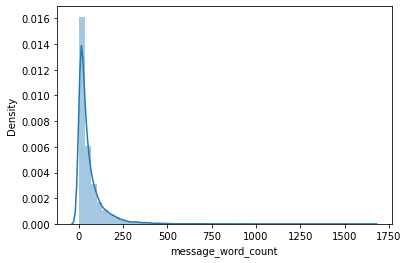

In [63]:
sns.distplot(df.loc[df['subreddit'] == "doordash", 'message_word_count'])

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='message_word_count', ylabel='Density'>

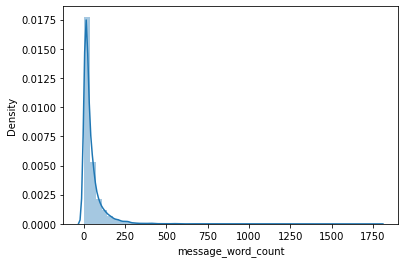

In [64]:
sns.distplot(df.loc[df['subreddit'] == "UberEATS", 'message_word_count'])

The post lengths look rather similar between our company and that of DoorDash's community. There is a peak below 100 and it is almost evenly distributed, but with a visible right skew.

### Finding top words

#### 1 - gram for DD

In [234]:
#stop words here
stop_words = 'dd', 'ue','dashers', 'dashing', 'dashpass', 'eats','door', 'dash', 'doordash', 'Uber', 'UberEATS', 'ubereats', 'uber', 'dasher', 'both', 'indeed', 'since', 'he', 'him', 'itself', 'side', 'found', 'further', 'give', 'otherwise', 'behind', 'why', 'too', 'hundred', 'ie', 'these', 'becomes', 'five', 'one', 'may', 'me', 'sometimes', 'serious', 'somewhere', 'front', 'take', 'all', 'un', 'himself', 'neither', 'latter', 'anything', 'become', 'she', 'twenty', 'also', 'namely', 'anyone', 'over', 'own', 'almost', 'only', 'eg', 'back', 'throughout', 'besides', 'hers', 'latterly', 'once', 'of', 'each', 'please', 'made', 'most', 'if', 'often', 'detail', 'under', 'without', 'who', 'amount', 'nobody', 'moreover', 'keep', 'whether', 'none', 'bottom', 'whereas', 'not', 'its', 'six', 'more', 'everywhere', 'had', 'together', 'there', 'but', 'con', 'everything', 'find', 'whereby', 'yourself', 'whole', 'which', 'off', 'forty', 'whose', 'eight', 'them', 'mine', 'seemed', 'rather', 'they', 'whence', 'couldnt', 'hereby', 'even', 'then', 'therefore', 'anywhere', 'until', 'beforehand', 'everyone', 'thereupon', 'upon', 'with', 'top', 'show', 'some', 'first', 'up', 'two', 'seems', 'sometime', 'see', 'mostly', 'thin', 'after', 'yourselves', 'enough', 'never', 'for', 'fifteen', 'alone', 'de', 'formerly', 'part', 'being', 'interest', 'move', 'twelve', 'do', 'you', 'herein', 'other', 'any', 'be', 'via', 'empty', 'how', 'were', 'nevertheless', 'must', 'though', 'thus', 'thick', 'towards', 'fill', 'from', 'call', 'seem', 'get', 'her', 'former', 'sincere', 'that', 'now', 're', 'already', 'in', 'where', 'so', 'beyond', 'we', 'about', 'those', 'before', 'a', 'last', 'the', 'eleven', 'seeming', 'fifty', 'his', 'afterwards', 'least', 'something', 'ours', 'what', 'therein', 'hasnt', 'nine', 'less', 'few', 'i', 'at', 'name', 'every', 'meanwhile', 'should', 'been', 'amongst', 'same', 'although', 'many', 'by', 'three', 'cry', 'thence', 'on', 'ever', 'anyway', 'yours', 'per', 'whom', 'around', 'hereupon', 'somehow', 'system', 'has', 'else', 'because', 'beside', 'between', 'noone', 'co', 'done', 'either', 'myself', 'us', 'into', 'might', 'however', 'our', 'down', 'is', 'etc', 'am', 'while', 'others', 'inc', 'describe', 'wherein', 'along', 'third', 'someone', 'my', 'an', 'four', 'fire', 'hence', 'whereupon', 'within', 'can', 'as', 'anyhow', 'whither', 'whenever', 'themselves', 'well', 'their', 'will', 'or', 'above', 'across', 'cant', 'thereafter', 'thereby', 'ourselves', 'ltd', 'herself', 'bill', 'sixty', 'mill', 'onto', 'put', 'much', 'through', 'such', 'very', 'whoever', 'out', 'below', 'go', 'this', 'elsewhere', 'no', 'when', 'amoungst', 'nowhere', 'whatever', 'hereafter', 'next', 'wherever', 'perhaps', 'another', 'again', 'among', 'to', 'could', 'would', 'became', 'your', 'whereafter', 'several', 'nor', 'than', 'was', 'it', 'and', 'except', 'against', 'here', 'ten', 'nothing', 'becoming', 'full', 'cannot', 'still', 'thru', 'have', 'always', 'during', 'yet', 'are', 'toward', 'due'

In [66]:
  # Instantiate vectorizer
vec = CountVectorizer(stop_words= stop_words, ngram_range=(1,1))

    # Fit the vectorizer on ZeroWaste text
vec.fit(dd["message"])

    # Transform the data
dat_dd_mono = vec.transform(dd["message"])





In [67]:
dat_dd_mono = pd.DataFrame(dat_dd_mono.todense(),
                  columns=vec.get_feature_names())
dat_dd_mono

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,0000,000th,001112,002,003,004,006,00am,...,zoodles,zoom,zoomed,zooming,ztxbmrg,zuck,zukerberg,ẗroubleshoot,⁰⁰,𝐌𝐞
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
dat_dd_mono.sum().sort_values(ascending=False).head(25)

order         9628
just          6787
orders        4449
like          4194
food          3953
time          3835
tip           3815
app           3339
don           3299
customer      3228
got           3193
know          3004
delivery      2990
ve            2951
pay           2636
dd            2129
make          2015
restaurant    1920
support       1916
minutes       1852
driver        1852
said          1842
people        1796
didn          1758
way           1674
dtype: int64

In [71]:
topdd_mono_words = dat_dd_mono.sum().sort_values(ascending=False).head(25)

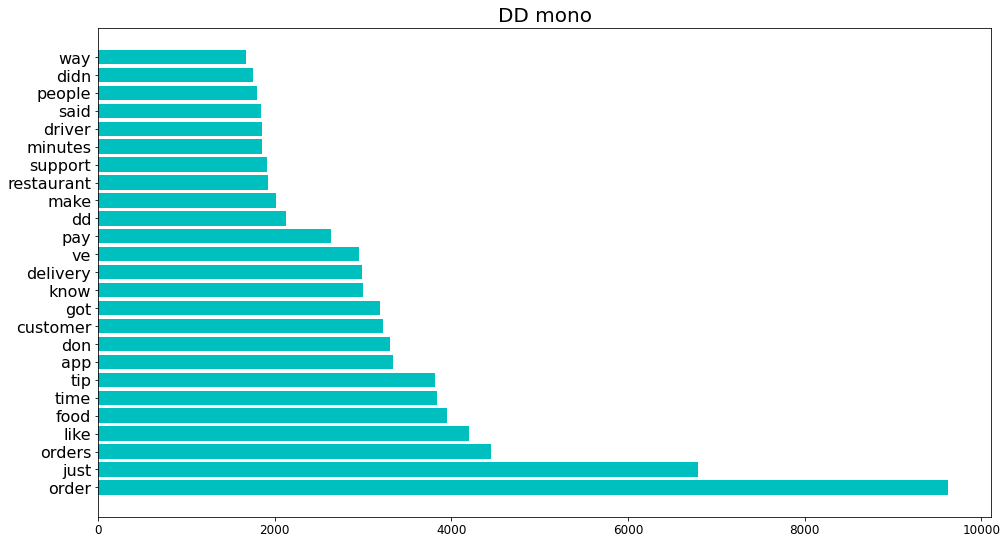

In [73]:
plt.figure(figsize=(16,9))
plt.barh(
    topdd_mono_words.index,
    topdd_mono_words.values,
    color= 'c'
    )
plt.title("DD mono", fontsize = 20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=16)

Our top-words are encapsulated as above. These are for one-grams for DD.

#### 2-gram for DD

In [75]:
  # Instantiate vectorizer
vec = CountVectorizer(stop_words=stop_words, ngram_range=(2,2), max_df= 0.8, min_df= 3)

    # Fit the vectorizer on ZeroWaste text
vec.fit(dd["message"])


    # Transform the data
dat_dd_bi = vec.transform(dd["message"])




In [76]:
    # Convert to a dataframe
dat_dd_bi = pd.DataFrame(dat_dd_bi.todense(),
                    columns=vec.get_feature_names())
dat_dd_bi

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00 00,00 10,00 30,00 50,00 base,00 completing,00 customer,00 delivery,00 dollars,00 gas,...,zone like,zone live,zone make,zone orders,zone peak,zone pick,zone sure,zone ve,zone way,zone wondering
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
dat_dd_bi.sum().sort_values(ascending=False).head(25)

don know            423
base pay            343
peak pay            342
amp x200b           338
don want            328
10 minutes          273
feel like           269
miles away          249
acceptance rate     243
red card            241
customer service    239
30 minutes          238
make sure           235
20 minutes          229
taco bell           219
just got            217
ve seen             215
let know            213
completion rate     211
gas prices          208
got order           199
view poll           194
fast pay            191
order just          185
15 minutes          180
dtype: int64

In [78]:
topdd_bi_words = dat_dd_bi.sum().sort_values(ascending=False).head(25)

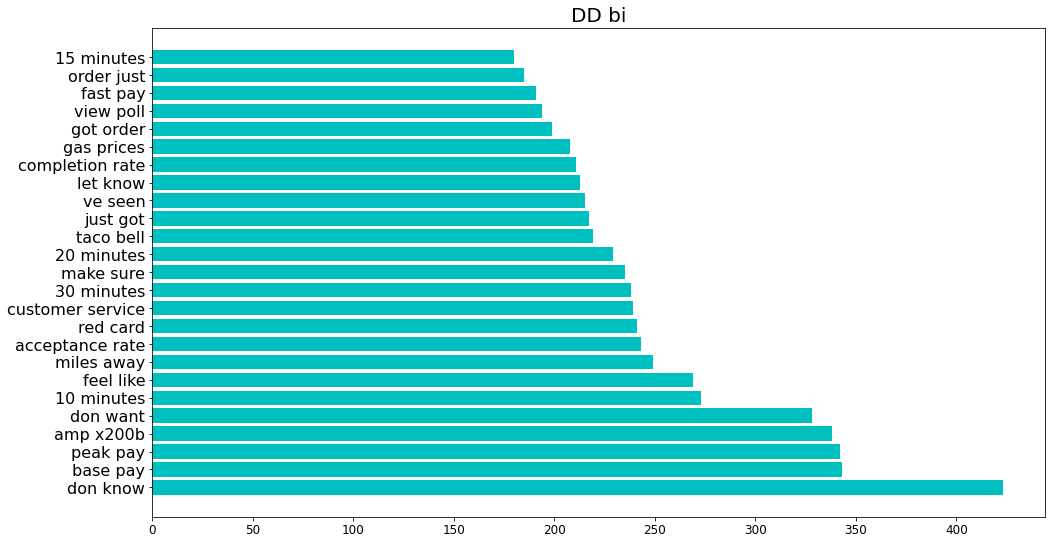

In [79]:
plt.figure(figsize=(16,9))
plt.barh(
    topdd_bi_words.index,
    topdd_bi_words.values,
    color= 'c'
    )
plt.title("DD bi", fontsize = 20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=16)

In [462]:
Our top-words are encapsulated as above. These are for bigrams for DD. There seems to be many words that are related to time, and a lot of people "don't know" certain situations or answers.

SyntaxError: invalid syntax (<ipython-input-462-e012a29f802e>, line 1)

#### 1- gram for UE

In [85]:
  # Instantiate vectorizer
vec = CountVectorizer(stop_words= stop_words, ngram_range=(1,1))

    # Fit the vectorizer on ZeroWaste text
vec.fit(ue["message"])

    # Transform the data
dat_ue = vec.transform(ue["message"])

dat_ue = pd.DataFrame(dat_ue.todense(),
                    columns=vec.get_feature_names())

dat_ue.sum().sort_values(ascending=False).head(25)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


order         7092
just          5279
tip           3748
delivery      3480
orders        3340
like          3307
food          3046
time          2963
got           2704
app           2598
customer      2570
don           2460
ve            2460
know          2362
driver        2325
drivers       1748
restaurant    1641
make          1622
support       1574
good          1574
people        1571
does          1515
going         1467
day           1466
today         1459
dtype: int64

In [86]:
topue_mono_words = dat_ue.sum().sort_values(ascending=False).head(25)

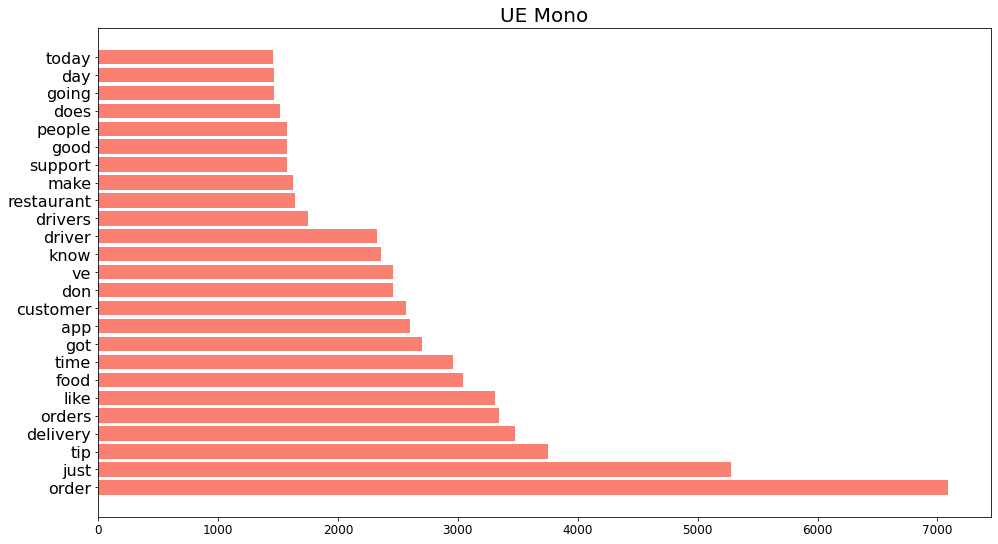

In [88]:
plt.figure(figsize=(16,9))
plt.barh(
    topue_mono_words.index,
    topue_mono_words.values,
    color= 'salmon'
    )
plt.title("UE Mono", fontsize = 20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=16)

Compared to DD, one interesting observation is that we have "good" as one of our top words. This might be worth exploring.

#### 2-gram for UE

In [80]:
  # Instantiate vectorizer
vec = CountVectorizer(stop_words= stop_words, ngram_range=(2,2), max_df= 0.8, min_df= 3)

    # Fit the vectorizer on ZeroWaste text
vec.fit(ue["message"])

    # Transform the data
data_ue_bi = vec.transform(ue["message"])




In [81]:
    # Convert to a dataframe
data_ue_bi = pd.DataFrame(data_ue_bi.todense(),
                    columns=vec.get_feature_names())
data_ue_bi

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00 delivery,00 mile,00 miles,00 order,00 orders,00 tip,00 trip,000 club,000 deliveries,000 miles,...,young woman,youtube video,youtube videos,zero orders,zero pings,zero sense,zero tip,zero tips,zip code,zone getting
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
data_ue_bi.sum().sort_values(ascending=False).head(25)

don know            314
good luck           302
feel like           261
don want            251
make money          228
tip baited          221
called support      209
cancel order        202
just got            201
amp x200b           197
let know            186
ve seen             173
food delivery       170
stay safe           169
customer service    167
make sure           159
miles away          157
delivery driver     155
background check    152
10 minutes          149
got order           148
taco bell           144
luck today          144
view poll           144
20 minutes          140
dtype: int64

In [83]:
topue_bi_words = data_ue_bi.sum().sort_values(ascending=False).head(25)

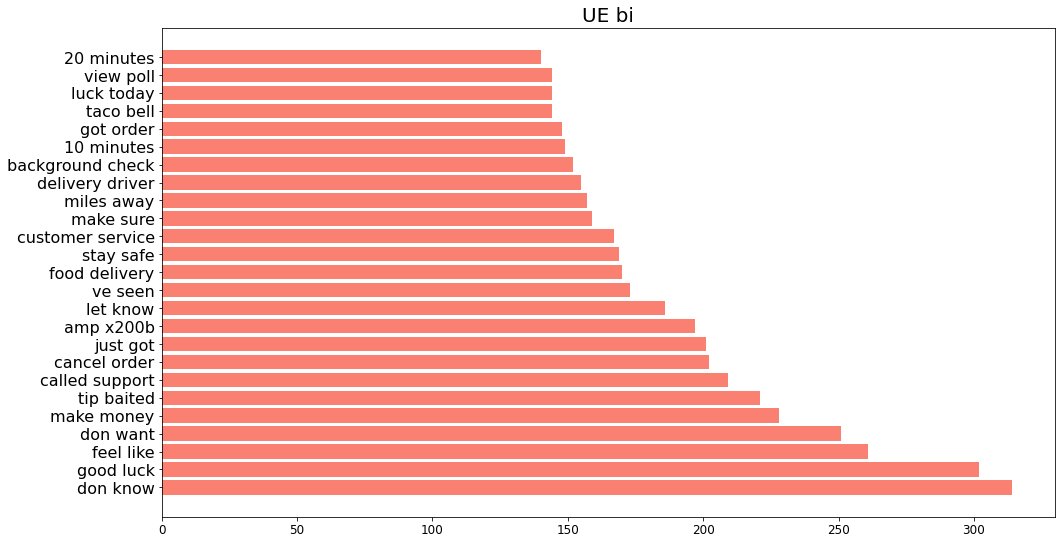

In [89]:
plt.figure(figsize=(16,9))
plt.barh(
    topue_bi_words.index,
    topue_bi_words.values,
    color= 'salmon'
    )
plt.title("UE bi", fontsize = 20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=16)

Similar to our competing company, a lot from our company also have time-related enquiries or views, and "don't know" with regards to certain situations or hypotheticals.

 ### Lemmatizing the texts 

In [66]:
df.shape

(20000, 7)

In [67]:
lemmatizer = WordNetLemmatizer()

In [68]:
df['tokenize']

0                                                                                   [How, do, I, request, my, town, get, bike, delivery, I, wanted, to, start, delivering, but, I, only, want, to, use, my, bike, I, live, in, a, small, town, and, when, I, signed, up, it, didn, t, give, me, an, option, to, use, a, bike, From, what, I, ve, seen, only, certain, towns, cities, have, the, option, for, bikes, Where, do, I, request, that, my, town, get, bike, deliveries, I, m, not, looking, to, make, tons, of, money, just, want, to, have, something, to, do, that, pairs, exercise, with, making, some]
1        [Newbie, question, about, stacked, orders, and, problems, with, app, gps, or, am, I, missing, something, Hey, everyone, Just, want, to, say, how, helpful, this, subreddit, has, been, I, m, new, to, DD, and, have, had, issues, with, stacked, orders, For, example, I, accept, a, Dash, for, two, orders, one, from, McDonald, s, and, the, other, at, Wendys, It, navigated, me, to, McDonald, s, and,

In [69]:
df['tokenize_lower'] = df['message'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [70]:
df['tokenize_lower'].head()

0                                                                               [how, do, i, request, my, town, get, bike, delivery, i, wanted, to, start, delivering, but, i, only, want, to, use, my, bike, i, live, in, a, small, town, and, when, i, signed, up, it, didn, t, give, me, an, option, to, use, a, bike, from, what, i, ve, seen, only, certain, towns, cities, have, the, option, for, bikes, where, do, i, request, that, my, town, get, bike, deliveries, i, m, not, looking, to, make, tons, of, money, just, want, to, have, something, to, do, that, pairs, exercise, with, making, some]
1    [newbie, question, about, stacked, orders, and, problems, with, app, gps, or, am, i, missing, something, hey, everyone, just, want, to, say, how, helpful, this, subreddit, has, been, i, m, new, to, dd, and, have, had, issues, with, stacked, orders, for, example, i, accept, a, dash, for, two, orders, one, from, mcdonald, s, and, the, other, at, wendys, it, navigated, me, to, mcdonald, s, and, when, i

In [71]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text.lower())]

In [72]:
df['lem'] = df['message'].apply(lemmatize_text)

In [73]:
df['lem']

0                                                                                    [how, do, i, request, my, town, get, bike, delivery, i, wanted, to, start, delivering, but, i, only, want, to, use, my, bike, i, live, in, a, small, town, and, when, i, signed, up, it, didn, t, give, me, an, option, to, use, a, bike, from, what, i, ve, seen, only, certain, town, city, have, the, option, for, bike, where, do, i, request, that, my, town, get, bike, delivery, i, m, not, looking, to, make, ton, of, money, just, want, to, have, something, to, do, that, pair, exercise, with, making, some]
1        [newbie, question, about, stacked, order, and, problem, with, app, gps, or, am, i, missing, something, hey, everyone, just, want, to, say, how, helpful, this, subreddit, ha, been, i, m, new, to, dd, and, have, had, issue, with, stacked, order, for, example, i, accept, a, dash, for, two, order, one, from, mcdonald, s, and, the, other, at, wendys, it, navigated, me, to, mcdonald, s, and, when, i, got

### Exploring the two dataframes together

In [74]:
df.shape

(20000, 9)

In [75]:
df.iloc[0]

subreddit                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     doordash
selftext                                                                                                                                           I wanted to start delivering but I only want to use my bike. I live in a small town and when I signed up, it didn't give me an option to use a bike. From what I've seen, only certain towns/cities have the option for bikes. Where do I request that my town get bike deliveries? I'm not looking to make tons of money, jus

We will assign 0 for doordash and 1 for UberEATS

In [76]:
df["subreddit"] = df["subreddit"].map({'doordash': 0, "UberEATS":1})

In [77]:
df["message"] = df["title"] + df["selftext"] 

In [78]:
pd.set_option('display.max_colwidth', None)

In [79]:
df["message"].isnull().sum()

0

In [80]:
df["subreddit"].isnull().sum()

0

# Baseline Test - Using Multinomial NB, CVEC, with no Params

In [441]:
X = df['message']
y = df['subreddit']

In [221]:
y.value_counts(normalize = True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

In [442]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [443]:
pipe = Pipeline([ #we included the words from the frozen set 'english' into our stop word list
    ('cvec', CountVectorizer(stop_words= stop_words)),
    ('nb', MultinomialNB())
])

In [444]:
pipe_params = {
}

#not defining any pipe_params for now

In [445]:
# find the optimal pipe_params then we will
# just include them in the pipe_params

In [446]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params,
                  cv=5) # 5-fold cross-validation

In [447]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=('dd', 'ue',
                                                                    'dashers',
                                                                    'dashing',
                                                                    'dashpass',
                                                                    'eats',
                                                                    'door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'ub

In [448]:
print(gs.best_score_) #with the words removed, hard to differentiate between 
#the two and we should get a low performance

0.650223880597015


In [449]:
gs.score(X_train, y_train)

0.8147761194029851

In [450]:
gs.score(X_test, y_test)

0.661060606060606

Our baseline accuracy between these two subreddits is about 65.0%, with stop words relating to DoorDash and UberEats removed.

# First model for Mulitnomial NB using CountVec

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [159]:
pipe = Pipeline([ #we included the words from the frozen set 'english' into our stop word list
    ('cvec', CountVectorizer(stop_words= stop_words)),
    ('nb', MultinomialNB())
])

In [233]:
pipe_params = {
    'cvec__max_features': [3_000, 4_000, 5_000, ,6_000, 10_000],
    'cvec__min_df': [3,4,5],
    'cvec__max_df': [0.8, 0.85, 0.9],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)]
}

In [234]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params,
                  cv=5) # 5-fold cross-validation

In [235]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=('dashers',
                                                                    'dashing',
                                                                    'dashpass',
                                                                    'eats',
                                                                    'door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'uber',
                                                                    'dasher

Which are the best params?

In [236]:
gs.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': 10000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 3)}

Getting the most important features out 

In [421]:
for x,y in zip(gs.best_estimator_[0].get_feature_names_out(), gs.best_estimator_[1].coef_.tolist()[0]):
    print(x,y)

00 -7.682245776358202
00 00 -10.887698580894263
00 50 -11.293163689002427
00 base -11.986310869562372
00 delivery -10.887698580894263
00 gallon -11.293163689002427
00 miles -10.887698580894263
00 order -10.600016508442481
00 orders -11.986310869562372
00 peak -11.986310869562372
00 tip -10.887698580894263
000 -8.552323665077225
000 deliveries -10.376872957128272
000 miles -11.293163689002427
00am -10.887698580894263
01 -9.906869327882536
02 -9.421361512100836
03 -10.376872957128272
04 -11.293163689002427
05 -10.600016508442481
06 -10.887698580894263
07 -11.293163689002427
09 -11.293163689002427
10 -6.097432911229491
10 00 -10.600016508442481
10 10 -9.789086292226152
10 12 -10.887698580894263
10 15 -9.21372214732259
10 20 -9.906869327882536
10 25 -10.887698580894263
10 30 -10.887698580894263
10 50 -11.986310869562372
10 bucks -10.887698580894263
10 cash -10.600016508442481
10 credit -11.293163689002427
10 days -10.376872957128272
10 deliveries -10.376872957128272
10 delivery -11.2931636

ball orders -10.194551400334317
balloons -10.040400720507058
balls -10.600016508442481
ban -9.789086292226152
bang -10.600016508442481
bank -7.7236309925210564
bank account -8.72821433154089
bank info -10.376872957128272
bank statement -9.906869327882536
banking -9.501404219774372
banking info -10.194551400334317
banned -8.654106359387168
bar -9.153097525506155
bare -11.293163689002427
bare minimum -11.986310869562372
barely -8.552323665077225
barking -10.600016508442481
base -7.796656127535947
base fare -9.906869327882536
base pay -8.430962808072959
base pays -10.887698580894263
based -8.22511075386881
based distance -11.293163689002427
basic -9.683725776568327
basically -8.20212123564411
basis -10.600016508442481
batch -9.21372214732259
batch order -10.194551400334317
batches -10.887698580894263
bathroom -9.789086292226152
bathrooms -10.194551400334317
battery -9.041871890395932
battle -10.887698580894263
bay -9.21372214732259
bay area -10.194551400334317
bbq -10.600016508442481
bc -

contact delivery -10.887698580894263
contact driver -10.376872957128272
contact support -8.489803308095892
contacted -8.01601895601025
contacted customer -10.600016508442481
contacted support -8.94178843183895
contacting -9.347253539947113
contacting support -10.887698580894263
contactless -9.789086292226152
contactless delivery -10.600016508442481
containers -11.293163689002427
containing -11.293163689002427
content -9.501404219774372
content post -9.906869327882536
contents -11.293163689002427
context -9.501404219774372
continue -8.430962808072959
continued -9.906869327882536
continues -10.194551400334317
contract -9.683725776568327
contract violation -11.293163689002427
contract violations -10.887698580894263
contractor -8.990578596008381
contractors -9.041871890395932
contracts -10.887698580894263
control -8.619015039575897
convenience -10.376872957128272
convenience store -10.600016508442481
convenient -9.906869327882536
conversation -10.194551400334317
convinced -10.8876985808942

don think -8.895268416204056
don time -10.040400720507058
don tip -9.153097525506155
don tips -10.376872957128272
don trust -10.376872957128272
don understand -8.489803308095892
don use -10.040400720507058
don usually -10.376872957128272
don wait -10.376872957128272
don wanna -10.194551400334317
don want -7.642505447708688
don way -10.887698580894263
don work -9.588415596764001
don worry -9.906869327882536
don wrong -10.376872957128272
dont -7.591861714889933
dont know -9.588415596764001
dont really -10.600016508442481
dont think -11.293163689002427
dont tip -10.600016508442481
dont use -10.887698580894263
dont want -9.683725776568327
donut -10.194551400334317
donuts -9.683725776568327
door -6.0946666577366
door apartment -10.887698580894263
door app -10.887698580894263
door bell -11.293163689002427
door closed -10.887698580894263
door customer -10.194551400334317
door dasher -11.986310869562372
door dashers -11.986310869562372
door dashing -11.986310869562372
door deliver -11.98631086

french fries -10.600016508442481
frequent -9.906869327882536
frequently -8.895268416204056
fresh -9.789086292226152
friday -7.943259601727822
friday night -9.501404219774372
friday saturday -10.194551400334317
fridays -10.376872957128272
friend -8.520574966762645
friendly -9.501404219774372
friends -8.552323665077225
friends family -10.600016508442481
fries -8.94178843183895
froze -10.887698580894263
frozen -9.789086292226152
fruit -11.293163689002427
frustrated -9.095939111666208
frustrating -8.459950344946211
frustration -10.040400720507058
fry -10.887698580894263
ft -10.887698580894263
fu -10.600016508442481
fuck -7.38114068357428
fuck fuck -11.293163689002427
fucked -8.850816653633222
fuckin -10.376872957128272
fucking -7.61686301709535
fucking app -11.293163689002427
fucks -10.376872957128272
fuel -7.8754370053890606
fuel assistance -9.21372214732259
fuel price -10.600016508442481
fuel surcharge -9.21372214732259
fuel surcharges -10.376872957128272
fulfill -10.194551400334317
fulf

italian -11.293163689002427
item -7.8919663073402715
item missing -10.887698580894263
item order -10.194551400334317
items -7.5554940707190585
items delivered -10.887698580894263
items miles -11.293163689002427
items missing -10.040400720507058
items order -10.376872957128272
iv -10.194551400334317
ive -8.459950344946211
jack -9.683725776568327
jack box -9.906869327882536
jacket -10.600016508442481
jail -10.887698580894263
jan -9.789086292226152
january -8.348724709835986
japan -10.194551400334317
jeep -10.600016508442481
jerk -10.600016508442481
jersey -10.040400720507058
jesus -9.789086292226152
job -6.62972459489036
job don -10.376872957128272
job job -10.887698580894263
job make -10.194551400334317
job pays -11.293163689002427
job right -10.194551400334317
job time -10.376872957128272
job ve -10.600016508442481
jobs -8.375392956918148
joe -9.347253539947113
john -10.376872957128272
johns -10.040400720507058
join -9.588415596764001
joined -9.347253539947113
joining -10.1945514003343

minutes ago -9.21372214732259
minutes away -8.489803308095892
minutes customer -11.293163689002427
minutes delivery -10.376872957128272
minutes driver -10.040400720507058
minutes early -10.600016508442481
minutes food -10.194551400334317
minutes hold -10.040400720507058
minutes hour -10.887698580894263
minutes house -11.986310869562372
minutes late -11.293163689002427
minutes later -8.654106359387168
minutes make -10.600016508442481
minutes order -10.600016508442481
minutes pick -11.293163689002427
minutes picking -10.376872957128272
minutes store -11.293163689002427
minutes support -10.376872957128272
minutes time -9.683725776568327
minutes total -11.293163689002427
minutes trying -10.887698580894263
minutes ve -10.887698580894263
minutes wait -10.376872957128272
minutes waiting -9.683725776568327
misc -10.376872957128272
misdemeanor -10.376872957128272
misleading -10.887698580894263
miss -8.94178843183895
missed -8.767435044694171
missing -7.142123783103781
missing food -10.600016508

past days -9.501404219774372
past months -9.683725776568327
past week -9.906869327882536
past weeks -9.501404219774372
past year -10.887698580894263
past years -10.194551400334317
paste -9.501404219774372
paste link -9.906869327882536
pasted -10.887698580894263
path -10.887698580894263
pathetic -10.376872957128272
patience -9.789086292226152
patient -10.194551400334317
patrick -9.789086292226152
patrick day -9.789086292226152
pattern -10.600016508442481
pause -9.588415596764001
pause button -10.376872957128272
pause timer -11.986310869562372
paused -10.040400720507058
pausing -10.600016508442481
pax -9.906869327882536
pay -5.81879437867403
pay 00 -11.293163689002427
pay 10 -11.293163689002427
pay 25 -11.293163689002427
pay 50 -10.376872957128272
pay 75 -11.293163689002427
pay adjustment -11.986310869562372
pay area -10.887698580894263
pay attention -10.887698580894263
pay base -10.887698580894263
pay better -10.194551400334317
pay bills -10.194551400334317
pay card -10.040400720507058


reply -8.72821433154089
report -7.579591622298119
report driver -10.376872957128272
reported -8.348724709835986
reporting -9.683725776568327
reports -10.040400720507058
repost -10.887698580894263
representative -10.194551400334317
reps -10.600016508442481
request -7.695851428413981
request refund -10.040400720507058
requested -8.850816653633222
requesting -10.887698580894263
requests -7.796656127535947
require -9.501404219774372
required -8.22511075386881
requirement -9.041871890395932
requirements -9.421361512100836
requires -10.040400720507058
requiring -9.906869327882536
research -9.153097525506155
reset -9.588415596764001
resets -10.887698580894263
resetting -11.293163689002427
residence -9.789086292226152
residential -9.906869327882536
resolution -10.887698580894263
resolve -9.683725776568327
resolve issue -10.600016508442481
resolved -10.194551400334317
resort -10.376872957128272
resources -10.194551400334317
respect -9.501404219774372
respectful -10.600016508442481
respond -8.55

stomach -10.194551400334317
stone -10.600016508442481
stood -10.887698580894263
stop -7.066329943734247
stop accepting -10.887698580894263
stop app -10.040400720507058
stop complaining -11.293163689002427
stop dashing -11.986310869562372
stop doing -10.887698580894263
stop getting -10.376872957128272
stop giving -10.376872957128272
stop orders -10.887698580894263
stop sending -10.887698580894263
stop taking -10.376872957128272
stop working -10.194551400334317
stopped -8.094490571451745
stopped doing -9.906869327882536
stopped using -10.887698580894263
stopped working -11.293163689002427
stopping -10.040400720507058
stops -8.990578596008381
store -7.411599891058989
store closed -10.600016508442481
store don -10.887698580894263
store manager -11.293163689002427
store order -11.986310869562372
store orders -10.194551400334317
store pick -11.293163689002427
store said -11.986310869562372
stores -8.94178843183895
stories -9.588415596764001
storm -8.850816653633222
storms -10.600016508442481

unaware -10.887698580894263
unbelievable -10.600016508442481
uncle -11.986310869562372
uncomfortable -10.040400720507058
uncommon -10.887698580894263
undelivered -10.887698580894263
underage -10.376872957128272
underpaid -11.293163689002427
understaffed -11.986310869562372
understand -7.361338056278101
understand customers -10.887698580894263
understand people -10.600016508442481
understandable -10.376872957128272
understanding -8.94178843183895
understands -10.887698580894263
understood -10.376872957128272
unemployment -9.683725776568327
unethical -10.600016508442481
unexpected -11.293163689002427
unfair -10.600016508442481
unfortunate -10.376872957128272
unfortunately -8.72821433154089
unicorn -8.157669473073277
unicorns -10.600016508442481
uninstall -10.600016508442481
uninstalled -10.600016508442481
uninstalled reinstalled -10.887698580894263
uninstalling -10.600016508442481
union -9.278260668460161
unique -10.376872957128272
unit -9.278260668460161
unit number -10.600016508442481


Running one more time with the best params

In [445]:
X = df['message']
y = df['subreddit']

In [446]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [448]:
### CHANGE THESE
pipe_params = {
    'cvec__max_features': [8_000, 9_000, 10_000, 11_000, 12_000],
    'cvec__min_df': [1,2],
    'cvec__max_df': [0.65, 0.7, 0.75, 0.8],
    'cvec__ngram_range': [(1,1),(1,2)]
}

In [449]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params,
                  cv=5) # 5-fold cross-validation

In [450]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['just',
                                                                    'like',
                                                                    'got',
                                                                    'didn',
                                                                    'did',
                                                                    'both',
                                                                    'indeed',
                                                                    'since',
                                                                    'he', 'him',
                                                                    'itself',
                                                                    'side',
                                                                    'found',
            

What are the most important features now?

In [451]:
gs.best_params_

{'cvec__max_df': 0.65,
 'cvec__max_features': 10000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

In [452]:
print(gs.best_score_) #with the words removed, hard to differentiate between 
#the two and we should get a low performance

0.705


In [453]:
gs.score(X_train, y_train)

0.8065671641791045

In [454]:
gs.score(X_test, y_test)

0.7027272727272728

The best score here is 

Best Params:

{'cvec__max_df': 0.65,
 'cvec__max_features': 10000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

print(gs.best_score_): 0.705

print(gs.best_score_): 0.8065671641791045

gs.score(X_test, y_test): 0.7027272727272728

## Optimizing... 

In [455]:
X = df['message']
y = df['subreddit']

In [456]:
### CHANGE THESE
pipe_params = {
    'cvec__max_features': [9_500, 10_000, 10_500],
    'cvec__min_df': [1,2],
    'cvec__max_df': [0.45, 0.5, 0.55, 0.6, 0.65],
    'cvec__ngram_range': [(1,1),(1,2)]
}

In [457]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params,
                  cv=5) # 5-fold cross-validation

In [458]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['just',
                                                                    'like',
                                                                    'got',
                                                                    'didn',
                                                                    'did',
                                                                    'both',
                                                                    'indeed',
                                                                    'since',
                                                                    'he', 'him',
                                                                    'itself',
                                                                    'side',
                                                                    'found',
            

In [459]:
gs.best_params_

{'cvec__max_df': 0.45,
 'cvec__max_features': 10000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

In [461]:
print(gs.best_score_) #with the words removed, hard to differentiate between 
#the two and we should get a low performance

0.705


In [462]:
gs.score(X_train, y_train)

0.8065671641791045

In [463]:
gs.score(X_test, y_test)

0.7027272727272728

The values of the scores does not seem to improve. We wil take this params as our final params. 

{'cvec__max_df': 0.45,
 'cvec__max_features': 10000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

### Running the Best Params once for posteriority

In [434]:
X = df['message']
y = df['subreddit']

In [435]:
### CHANGE THESE
pipe_params = {
    'cvec__max_features': [10_000],
    'cvec__min_df': [1],
    'cvec__max_df': [0.45],
    'cvec__ngram_range': [(1,1),(1,2)]
}

In [436]:
gs_nb_cvec = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params,
                  cv=5) # 5-fold cross-validation

In [437]:
gs_nb_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=('dashers',
                                                                    'dashing',
                                                                    'dashpass',
                                                                    'eats',
                                                                    'door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'uber',
                                                                    'dasher

In [438]:
print(gs_nb_cvec.best_score_) #with the words removed, hard to differentiate between 
#the two and we should get a low performance

0.6680597014925374


In [439]:
gs_nb_cvec.score(X_train, y_train)

0.7910447761194029

In [440]:
gs_nb_cvec.score(X_test, y_test)

0.6731818181818182

Importantly, our accuracy has increased from 65.0% to 66.8%

### Coeff dataframe (for Multinomial, CVEC)

In [165]:
gs_nb_cvec.best_estimator_[1].coef_.shape

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


(1, 10000)

In [166]:
gs_nb_cvec.best_estimator_[1].feature_log_prob_

array([[ -7.17239079, -10.16185345, -10.44953552, ...,  -8.74478743,
        -10.85500063, -10.85500063],
       [ -7.71809072, -11.32900864, -11.32900864, ...,  -9.71957072,
         -9.94271428, -10.92354353]])

In [167]:
delta = gs_nb_cvec.best_estimator_[1].feature_log_prob_[1,:] - gs_nb_cvec.best_estimator_[1].feature_log_prob_[0,:]

In [168]:
delta_pd = pd.DataFrame(delta)

In [169]:
mn_cvec_df = []
for x,y in zip(gs_nb_cvec.best_estimator_[0].get_feature_names_out(), delta):
    mn_cvec_df.append([x, y])

In [170]:
mn_cvec_df

[['00', -0.5456999347426992],
 ['00 00', -1.1671551868465286],
 ['00 50', -0.879473114394747],
 ['00 base', -1.860302367406474],
 ['00 delivery', -0.06854289817841952],
 ['00 gallon', -0.6971515576007921],
 ['00 miles', -0.29168644949262834],
 ['00 order', -0.3404766136620605],
 ['00 orders', -1.7267709747819513],
 ['00 peak', -1.7267709747819513],
 ['00 tip', -0.8794731143947487],
 ['000', -0.010435267371136092],
 ['000 deliveries', 0.03681761747940726],
 ['000 miles', -1.3902987381607375],
 ['001112', -1.5726202949546924],
 ['001112 206', -1.5726202949546924],
 ['00am', -0.29168644949262834],
 ['01', -0.3404766136620605],
 ['02', 0.7046469900550623],
 ['03', 0.21913917427336216],
 ['04', -0.6971515576007921],
 ['05', -0.6971515576007921],
 ['06', -0.6281586861138422],
 ['06 001112', -1.5726202949546924],
 ['07', -1.033623794222006],
 ['09', -1.2849382225029125],
 ['10', -0.2163418297750681],
 ['10 00', -0.004004377040846663],
 ['10 10', 2.416363751609582],
 ['10 12', -0.2916864494926

In [171]:
mn_cvec_coef = pd.DataFrame(mn_cvec_df, columns = ['Word', 'mn_cvec Coeff'])

mn_cvec_coef['mn_cvec Coeff'] = mn_cvec_coef['mn_cvec Coeff']

mn_cvec_coef.sort_values('mn_cvec Coeff', ascending=True).head(25)

,Word,mn_cvec Coeff
3205,fast pay,-3.939744
2059,dasherdirect,-3.841304
1685,completion rate,-3.769845
7203,red card,-3.672681
6532,peak pay,-3.652062
2058,dashed,-3.494433
7833,settlement,-3.444422
4699,kashish,-3.336209
4711,kenneth,-3.307221
4700,kashish 25,-3.277368


In [172]:
mn_cvec_coef.sort_values('mn_cvec Coeff', ascending=False).head(25)

,Word,mn_cvec Coeff
7010,quests,4.262190
8157,starbucks,3.932711
9160,uk,3.908019
3197,fare,3.653126
7001,quest,3.603529
8464,surges,3.551344
6750,plus card,3.551344
9243,upfront addresses,3.397193
8459,surge,3.310182
7628,satisfaction rate,3.163578


In [173]:
mn_1 = mn_cvec_coef.sort_values('mn_cvec Coeff', ascending=True).head(25)

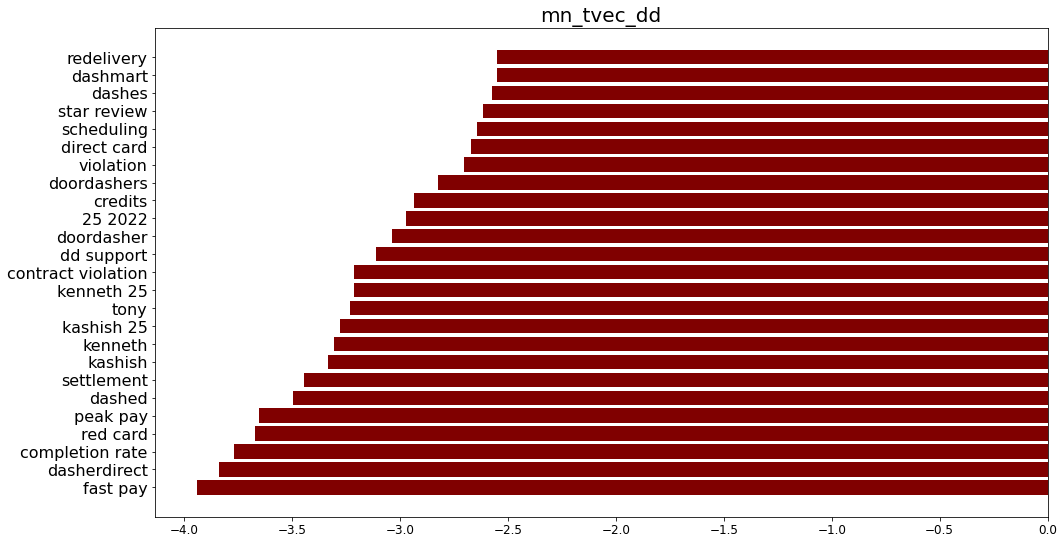

In [174]:
plt.figure(figsize=(16,9))
plt.barh(mn_1["Word"], mn_1["mn_cvec Coeff"], color ='maroon')
 
plt.title("mn_tvec_dd", fontsize = 20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=16)

In [175]:
mn_2 = mn_cvec_coef.sort_values('mn_cvec Coeff', ascending=False).head(25)

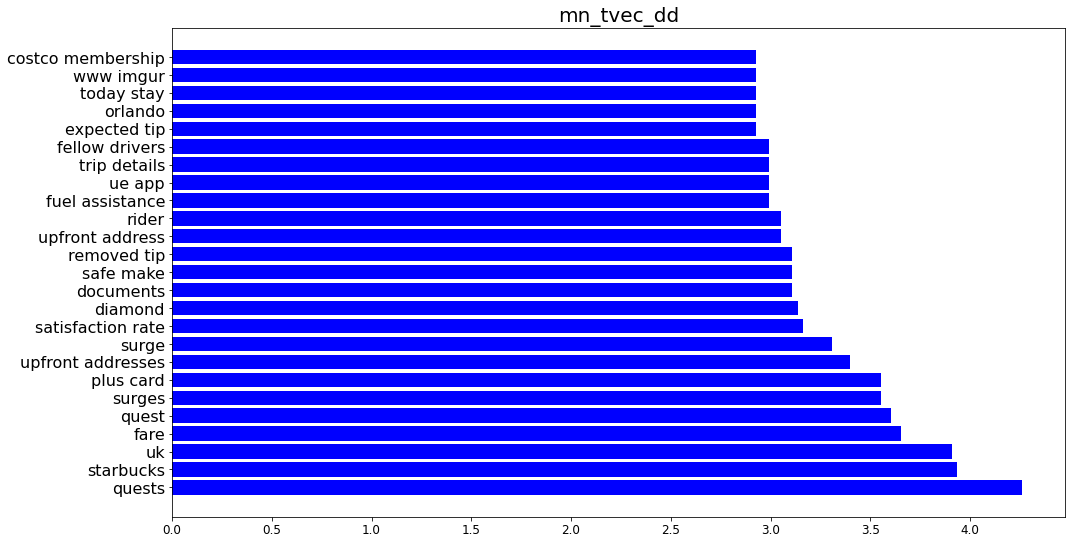

In [176]:
plt.figure(figsize=(16,9))
plt.barh(mn_2["Word"], mn_2["mn_cvec Coeff"], color ='blue')
 
plt.title("mn_tvec_dd", fontsize = 20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=16)

### Predictions using Multinomial NB, CVEC

In [264]:
# Get predictions, confusion matrix
preds_cvec = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvec).ravel()
# Calculate the specificity
spec = tn / (tn + fp)



In [265]:
print('Specificity:', spec)

Specificity: 0.6912121212121212


# Mulitnomial NB using TVEC

In [165]:
tvec = TfidfVectorizer()

In [176]:
pipe_tvec = Pipeline([ #we included the words from the frozen set 'english' into our stop word list
    ('tvec', TfidfVectorizer(stop_words = stop_words)),
    ('nb', MultinomialNB()),
     ])


In [177]:
pipe_tvec_params = {
    'tvec__max_features': [4000,5000],
    'tvec__ngram_range': [(1,1),(1,2)]
}

In [178]:
gs_tvec = GridSearchCV(
    pipe_tvec,
    param_grid=pipe_tvec_params,
    cv = 5
)

In [179]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=('door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'uber',
                                                                    'dasher',
                                                                    'both',
                                                                    'indeed',
                                                                    'since',
                                                                    'he', 'him',

In [199]:
gs_tvec.best_params_

{'tvec__max_df': 0.3,
 'tvec__max_features': 11000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 4)}

In [180]:
print(gs_tvec.best_score_)

0.6884328358208955


In [181]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.7967910447761194

In [182]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.6848484848484848

### Optimising

In [185]:
pipe_tvec = Pipeline([ #we included the words from the frozen set 'english' into our stop word list
    ('tvec', TfidfVectorizer(stop_words = stop_words),),
    ('nb', MultinomialNB()),
     ])


In [188]:
pipe_tvec_params = {
    'tvec__max_features': [9_000, 10_000, 11_000],
    'tvec__min_df': [1,2,3],
    'tvec__max_df': [0.45, 0.5, 0.55],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)]
}


In [119]:
gs_tvec = GridSearchCV(
    pipe_tvec,
    param_grid=pipe_tvec_params,
    cv = 5,
    n_jobs = -2
)

In [190]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=('door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'uber',
                                                                    'dasher',
                                                                    'both',
                                                                    'indeed',
                                                                    'since',
                                                                    'he', 'him',

In [191]:
gs_tvec.best_params_


{'tvec__max_df': 0.45,
 'tvec__max_features': 11000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 3)}

In [192]:
print(gs_tvec.best_score_)

0.6951492537313433


In [193]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.8376119402985075

In [194]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.6884848484848485

## Running one more time with the best params

In [195]:
pipe_tvec_params = {
    'tvec__max_features': [11_000, 13_000, 15_000],
    'tvec__min_df': [3, 4,5],
    'tvec__max_df': [0.3,0.35, 0.4,0.45],
    'tvec__ngram_range': [(1,3),(1,4)]
}


In [197]:
gs_tvec = GridSearchCV(
    pipe_tvec,
    param_grid=pipe_tvec_params,
    cv = 5,
    n_jobs = -1
)

In [198]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=('door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'uber',
                                                                    'dasher',
                                                                    'both',
                                                                    'indeed',
                                                                    'since',
                                                                    'he', 'him',

In [200]:
gs_tvec.best_params_

{'tvec__max_df': 0.3,
 'tvec__max_features': 11000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 4)}

In [201]:
print(gs_tvec.best_score_)

0.6957462686567164


In [202]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.8376865671641791

In [203]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.6872727272727273

# Optimizing

In [328]:
pipe_tvec_params = {
    'tvec__max_features': [11_000],
    'tvec__min_df': [3],
    'tvec__max_df': [0.2,0.25 ,0.3],
    'tvec__ngram_range': [(1,4),(1,5),(1,6)]
}


In [329]:
gs_tvec = GridSearchCV(
    pipe_tvec,
    param_grid=pipe_tvec_params,
    cv = 5,
    n_jobs = -1
)

In [330]:
gs_tvec.fit(X_train, y_train)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [207]:
gs_tvec.best_params_

{'tvec__max_df': 0.25,
 'tvec__max_features': 11000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 4)}

In [208]:
print(gs_tvec.best_score_)

0.6957462686567164


In [209]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.8376865671641791

In [210]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.6872727272727273

The best params have been optimised as such

{'tvec__max_df': 0.25,#not changing anymore as the best scores are not changing already
 'tvec__max_features': 11000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 4)}
 
 This model is better, with 69.6% in accuracy compared to 65% in the baseline and 66.8% in Mulitnomial NB, CVEC.

# Optimized best params: Multi NB TVEC 

In [178]:
X = df['message']
y = df['subreddit']

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [180]:
tvec = TfidfVectorizer()

In [181]:
pipe_tvec = Pipeline([ #we included the words from the frozen set 'english' into our stop word list
    ('tvec', TfidfVectorizer(stop_words = stop_words)),
    ('nb', MultinomialNB()),
     ])


In [182]:
pipe_tvec_params = {
    'tvec__max_features': [11_000],
    'tvec__min_df': [3],
    'tvec__max_df': [0.25],
    'tvec__ngram_range': [(1,4)],
}


In [183]:
gs_tvec = GridSearchCV(
    pipe_tvec,
    param_grid=pipe_tvec_params,
    cv = 5,
    n_jobs = -2
)

In [184]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=('dashers',
                                                                    'dashing',
                                                                    'dashpass',
                                                                    'eats',
                                                                    'door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'uber',
                                                                    'dasher

In [185]:
print(gs_tvec.best_score_)

0.6707462686567164


In [186]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.8254477611940298

In [187]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.6646969696969697

## Best estimator

In [201]:
gs_tvec.best_estimator_[1].feature_log_prob_

array([[ -7.62220321,  -9.73628691,  -9.90040285, ...,  -8.65903077,
        -10.15079014, -10.18474005],
       [ -8.12465942, -10.31196598, -10.35656383, ...,  -9.626958  ,
         -9.61214812,  -9.87968667]])

In [202]:
delta = gs_tvec.best_estimator_[1].feature_log_prob_[1,:] - gs_tvec.best_estimator_[1].feature_log_prob_[0,:]

In [203]:
delta_pd = pd.DataFrame(delta)

In [204]:
mn_tvec_df = []
for x,y in zip(gs_tvec.best_estimator_[0].get_feature_names_out(), delta):
    mn_tvec_df.append([x, y])

In [205]:
mn_tvec_df

[['00', -0.502456202823514],
 ['00 00', -0.575679073440277],
 ['00 50', -0.45616098625207613],
 ['00 base', -0.5606996432912528],
 ['00 base pay', -0.46172673237662565],
 ['00 miles', -0.11987589910337881],
 ['00 order', -0.24638628646187044],
 ['00 orders', -0.6010742460558909],
 ['00 peak', -0.7524907786784478],
 ['00 tip', -0.421334322733415],
 ['000', 0.2126894717566934],
 ['000 deliveries', 0.20398780794809923],
 ['000 miles', -0.2510382191015932],
 ['00am', 0.11548467369976656],
 ['01', -0.4505792801196371],
 ['02', 0.7804935273793507],
 ['03', 0.4403114610509622],
 ['05', -0.2357572039398228],
 ['06', 0.3879180550515535],
 ['07', -0.1664575499258305],
 ['09', -0.24122416656624956],
 ['10', -0.2669924589946602],
 ['10 00', 0.14072337671519008],
 ['10 10', 1.1534277898268055],
 ['10 12', -0.2794448385940811],
 ['10 15', -0.11735008828984661],
 ['10 15 minutes', -0.29639281184220145],
 ['10 20', 0.17958034606186146],
 ['10 25', -0.11938576195370487],
 ['10 30', -0.5150480018868056]

In [206]:
mn_tvec_coef = pd.DataFrame(mn_tvec_df, columns = ['Word', 'mn_tvec Coeff'])

mn_tvec_coef['mn_tvec Coeff'] = mn_tvec_coef['mn_tvec Coeff']

mn_tvec_coef.sort_values('mn_tvec Coeff', ascending=True).head(25)

,Word,mn_tvec Coeff
7092,peak pay,-2.668475
7817,red card,-2.649583
9847,tony,-2.494740
10377,violation,-2.481847
3381,fast pay,-2.366437
1874,contract violation,-2.353605
2111,dasherdirect,-2.282726
1873,contract,-2.267858
1795,completion rate,-2.171290
1962,crash,-2.167352


In [207]:
mn_tvec_coef.sort_values('mn_tvec Coeff', ascending=False).head(25)

,Word,mn_tvec Coeff
9187,surge,2.851081
7619,quests,2.766653
7606,quest,2.671623
7269,pings,2.583791
10066,uk,2.464488
1033,baiting,2.379687
9193,surges,2.302838
8866,starbucks,2.295455
9469,thumbs,2.276633
3368,fare,2.235107


In [208]:
mn_1 = mn_tvec_coef.sort_values('mn_tvec Coeff', ascending=True).head(25)

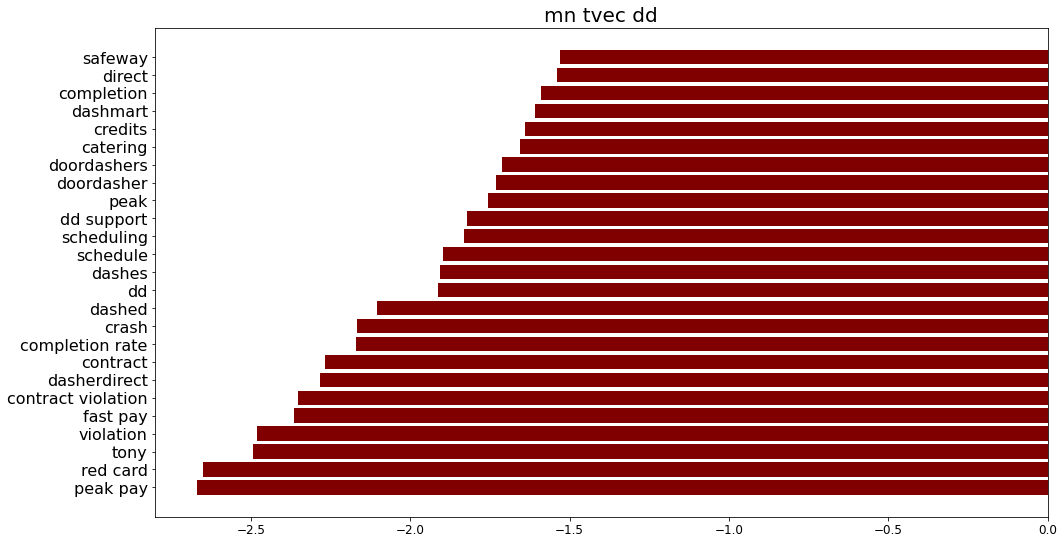

In [209]:
plt.figure(figsize=(16,9))
plt.barh(mn_1["Word"], mn_1["mn_tvec Coeff"], color ='maroon')
 
plt.title("mn tvec dd", fontsize = 20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=16)

In [210]:
mn_2 = mn_tvec_coef.sort_values('mn_tvec Coeff', ascending=False).head(25)

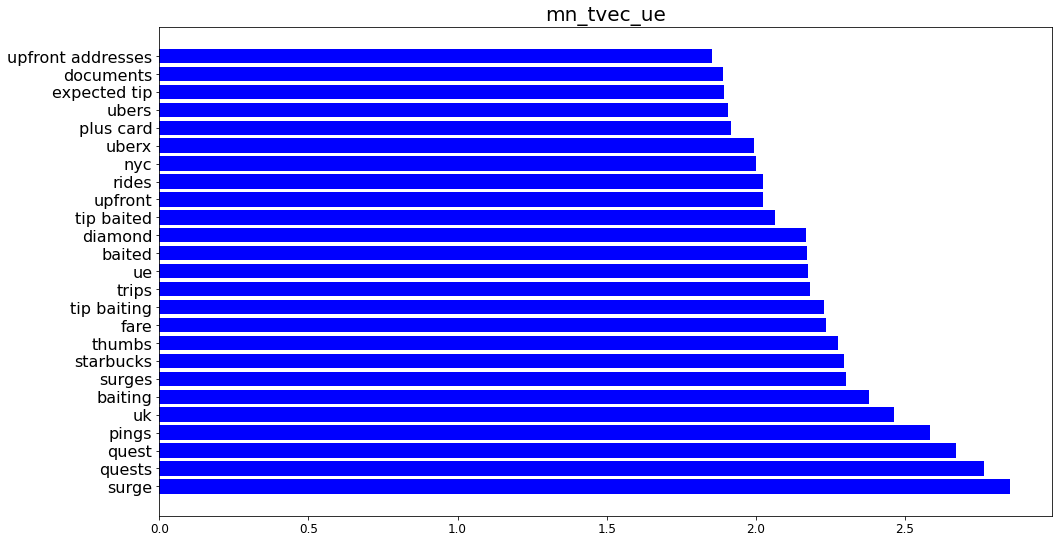

In [211]:
plt.figure(figsize=(16,9))
plt.barh(mn_2["Word"], mn_2["mn_tvec Coeff"], color ='blue')
 
plt.title("mn_tvec_ue", fontsize = 20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=16)

We can observe the top features, which we will use for analysis later.

## Confusion matrix

In [92]:
# Get predictions, confusion matrix
preds_cvec = gs_tvec.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvec).ravel()
# Calculate the specificity
spec = tn / (tn + fp)



In [93]:
spec

0.7272727272727273

# Using Random Forests: Without and with extra trees

In [142]:
X = df['message']
y = df['subreddit']

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [144]:
rf = RandomForestClassifier(n_estimators=100)

In [145]:
et = ExtraTreesClassifier(n_estimators=100)

rf_params = {
    'n_estimators': [100, 150, 200,250],
    'max_depth': [None, 1, 2, 3, 4, 5,6,7],
    'max_features': ['sqrt', 'log2', 0.5,0.7],
}

In [146]:
rf_params = {
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [3, 4, 5],
    'rf__max_features': ['sqrt', 'log2', 0.5,0.7],
    'rf__min_samples_split': [5, 10, 15],
    'rf__min_samples_leaf': [3, 4, 5],
    'rf__ccp_alpha': [0, 0.1, 1, 10],
}

In [147]:
et_params = {
    'et__n_estimators': [100, 150],
    'et__max_depth': [3, 4, 5],
    'et__max_features': ['sqrt', 'log2', 0.5,0.7],
    'et__min_samples_split': [5, 10, 15],
    'et__min_samples_leaf': [3, 4, 5],
    'et__ccp_alpha': [0, 0.1, 1, 10],
}

In [148]:
pipe_rf = Pipeline([ #we included the words from the frozen set 'english' into our stop word list
    ('cvec', TfidfVectorizer(stop_words = stop_words)),
    ('rf', RandomForestClassifier()),
     ])

In [149]:
pipe_et = Pipeline([ #we included the words from the frozen set 'english' into our stop word list
    ('cvec', TfidfVectorizer(stop_words = stop_words)),
    ('et', ExtraTreesClassifier()),
     ])

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000, 10_000],
    'cvec__min_df': [2,3,4],
    'cvec__max_df': [0.8, 0.85, 0.9, 0.95, 0.99],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)]
}

In [150]:
gs_rf_0 = GridSearchCV(pipe_rf, # what object are we optimizing?
                  param_grid = rf_params,
                  cv=5,
                 n_jobs = -1) # 5-fold cross-validation

In [151]:
gs_et_0 = GridSearchCV(pipe_et, # what object are we optimizing?
                  param_grid = et_params,
                  cv=5,
                 n_jobs = -1) # 5-fold cross-validation

In [153]:
gs_rf_0.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words=('dashers',
                                                                    'dashing',
                                                                    'dashpass',
                                                                    'eats',
                                                                    'door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'uber',
                                                                    'dasher

In [154]:
gs_et_0.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words=('dashers',
                                                                    'dashing',
                                                                    'dashpass',
                                                                    'eats',
                                                                    'door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'uber',
                                                                    'dasher

In [612]:
print(gs_rf_0.best_score_)

0.668955223880597


In [614]:
gs_rf_0.best_params_

{'rf__ccp_alpha': 0,
 'rf__max_depth': 5,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 4,
 'rf__min_samples_split': 15,
 'rf__n_estimators': 150}

In [615]:
print(gs.best_score_) #with the words removed, hard to differentiate between 
#the two and we should get a low performance

0.668955223880597


In [616]:
gs_rf_0.score(X_train, y_train)

0.6894029850746268

In [617]:
gs_rf_0.score(X_test, y_test)

0.6524242424242425

In [613]:
print(gs_et_0.best_score_)

0.6463432835820896


In [618]:
gs_et_0.best_params_

{'et__ccp_alpha': 0,
 'et__max_depth': 5,
 'et__max_features': 0.5,
 'et__min_samples_leaf': 5,
 'et__min_samples_split': 10,
 'et__n_estimators': 150}

In [619]:
gs_et_0.score(X_train, y_train)

0.6551492537313433

In [620]:
gs_et_0.score(X_test, y_test)

0.6413636363636364

## Re-running with new params to get the best model

In [120]:
rf_params = {
    'rf__n_estimators': [150, 200],
    'rf__max_depth': [5,6,7],
    'rf__max_features': ['sqrt'],
    'rf__min_samples_split': [15,20],
    'rf__min_samples_leaf': [5,6,7],
    'rf__ccp_alpha': [0, 0.1],
}

In [132]:
et_params = {
    'et__n_estimators': [150,200],
    'et__max_depth': ['none', 6, 7],
    'et__max_features': [0.5],
    'et__min_samples_split': [10],
    'et__min_samples_leaf': [5, 6, 7],
    'et__ccp_alpha': [0, 0.01],
}

In [122]:
pipe_rf = Pipeline([ #we included the words from the frozen set 'english' into our stop word list
    ('cvec', TfidfVectorizer(stop_words = stop_words)),
    ('rf', RandomForestClassifier()),
     ])

In [123]:
pipe_et = Pipeline([ #we included the words from the frozen set 'english' into our stop word list
    ('cvec', TfidfVectorizer(stop_words = stop_words)),
    ('et', ExtraTreesClassifier()),
     ])

In [124]:
gs_rf = GridSearchCV(pipe_rf, # what object are we optimizing?
                  param_grid = rf_params,
                  cv=5,
                  n_jobs = -1) # 5-fold cross-validation

In [125]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words=('dashers',
                                                                    'dashing',
                                                                    'dashpass',
                                                                    'eats',
                                                                    'door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'uber',
                                                                    'dasher

In [127]:
gs_rf.best_params_

{'rf__ccp_alpha': 0,
 'rf__max_depth': 7,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 7,
 'rf__min_samples_split': 15,
 'rf__n_estimators': 200}

In [129]:
print(gs_rf.best_score_) #with the words removed, hard to differentiate between 
#the two and we should get a low performance

0.640223880597015


In [130]:
gs_rf.score(X_train, y_train)

0.6748507462686567

In [131]:
gs_rf.score(X_test, y_test)

0.634090909090909

In [133]:
gs_et = GridSearchCV(pipe_et, # what object are we optimizing?
                  param_grid = et_params,
                  cv=5,
                  n_jobs = -1) # 5-fold cross-validation

In [134]:
gs_et.fit(X_train, y_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Asus\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Asus\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\Asus\anaconda3\lib\site-p

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words=('dashers',
                                                                    'dashing',
                                                                    'dashpass',
                                                                    'eats',
                                                                    'door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'uber',
                                                                    'dasher

In [212]:
gs_et.best_params_

{'et__ccp_alpha': 0,
 'et__max_depth': 6,
 'et__max_features': 0.5,
 'et__min_samples_leaf': 7,
 'et__min_samples_split': 10,
 'et__n_estimators': 200}

In [277]:
print(gs_et.best_score_) 

0.6058955223880597


In [214]:
gs_et.score(X_train, y_train)

0.612089552238806

In [215]:
gs_et.score(X_test, y_test)

0.6040909090909091

Our best for RF and ET are 64% and 60.6% respectively. Our best model for accuracy would be that of the Multinomial NB, TVEC.

# Best Params run for RF and ET

In [235]:
X = df['message']
y = df['subreddit']

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [237]:
rf = RandomForestClassifier(n_estimators=100)

In [238]:
et = ExtraTreesClassifier(n_estimators=100)

rf_params = {
    'n_estimators': [100, 150, 200,250],
    'max_depth': [None, 1, 2, 3, 4, 5,6,7],
    'max_features': ['sqrt', 'log2', 0.5,0.7],
}

In [245]:
rf_params = {
    'rf__n_estimators': [200],
    'rf__max_depth': ['none', 7],
    'rf__max_features': ['sqrt'],
    'rf__min_samples_split': [15],
    'rf__min_samples_leaf': [7],
    'rf__ccp_alpha': [0],
}

In [246]:
et_params = {
    'et__n_estimators': [200],
    'et__max_depth': [6],
    'et__max_features': [0.5],
    'et__min_samples_split': [10],
    'et__min_samples_leaf': [7],
    'et__ccp_alpha': [0],
}

In [278]:
gs_rf_3.best_params_

{'rf__ccp_alpha': 0,
 'rf__max_depth': 7,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 7,
 'rf__min_samples_split': 15,
 'rf__n_estimators': 200}

In [247]:
pipe_rf = Pipeline([ #we included the words from the frozen set 'english' into our stop word list
    ('cvec', TfidfVectorizer(stop_words = stop_words)),
    ('rf', RandomForestClassifier()),
     ])

In [248]:
pipe_et = Pipeline([ #we included the words from the frozen set 'english' into our stop word list
    ('cvec', TfidfVectorizer(stop_words = stop_words)),
    ('et', ExtraTreesClassifier()),
     ])

In [249]:
gs_rf_3 = GridSearchCV(pipe_rf, # what object are we optimizing?
                  param_grid = rf_params,
                  cv=5,
                 n_jobs = -1) # 5-fold cross-validation

In [250]:
gs_et_3 = GridSearchCV(pipe_et, # what object are we optimizing?
                  param_grid = et_params,
                  cv=5,
                 n_jobs = -1) # 5-fold cross-validation

In [251]:
gs_rf_3.fit(X_train, y_train)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Asus\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Asus\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\Asus\anaconda3\lib\site-pack

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words=('dd', 'ue',
                                                                    'dashers',
                                                                    'dashing',
                                                                    'dashpass',
                                                                    'eats',
                                                                    'door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'ub

In [252]:
gs_et_3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words=('dd', 'ue',
                                                                    'dashers',
                                                                    'dashing',
                                                                    'dashpass',
                                                                    'eats',
                                                                    'door',
                                                                    'dash',
                                                                    'doordash',
                                                                    'Uber',
                                                                    'UberEATS',
                                                                    'ubereats',
                                                                    'ub

## Finding the best estimators for our random forests

In [253]:
feature_names = gs_rf_3.best_estimator_[0].get_feature_names()

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [254]:
importances = gs_rf_3.best_estimator_[1].feature_importances_

In [255]:
rf_df = []
for x,y in zip(feature_names, importances):
    rf_df.append([x, y])

In [256]:
rf_impt = pd.DataFrame(rf_df, columns = ['Feature_Words', 'Importances'])

In [257]:
rf_impt

,Feature_Words,Importances
0,00,0.003754
1,000,0.000000
2,000km,0.000000
3,001112,0.000000
4,002,0.000000
...,...,...
18210,zukerberg,0.000000
18211,zupas,0.000000
18212,zw5jcnlwdgvkuxvhbglmawvypufcrvzwmtniwthfv1imzw5jcnlwdgvkswq9qta5nzg5odgyr1bpmuhcr0w4meffjmvuy3j5chrlzefkswq9qtazmdaynjezrulisvfnnvhcsjvwjndpzgdlde5hbwu9c3bfyxrmjmfjdglvbj1jbglja1jlzglyzwn0jmrvtm90tg9nq2xpy2s9dhj1zq,0.000000
18213,über,0.000000


In [261]:
rf_impt_25 = rf_impt.sort_values('Importances', ascending=False).head(25)

In [262]:
rf_impt_25 

,Feature_Words,Importances
11260,order,0.024672
16682,trips,0.018753
17437,violation,0.014908
11984,pings,0.014627
15357,store,0.012685
16206,thumbs,0.012570
16462,tony,0.012561
3937,completion,0.011071
8851,items,0.010929
7237,gas,0.010909


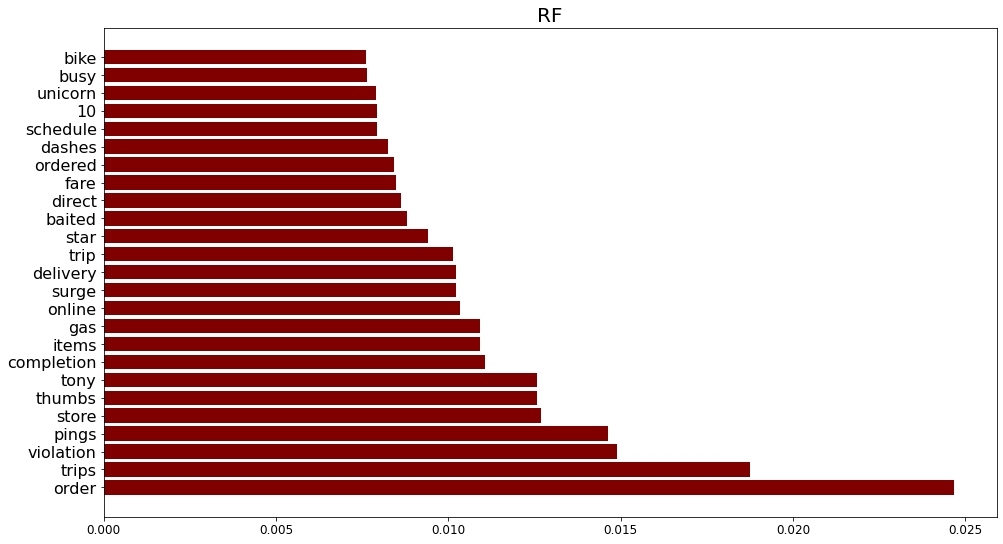

In [271]:
plt.figure(figsize=(16,9))
plt.barh(rf_impt_25["Feature_Words"], rf_impt_25["Importances"], color ='maroon')
 
plt.title("RF", fontsize = 20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=16)

In [272]:
feature_names_et = gs_et_3.best_estimator_[0].get_feature_names()

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [273]:
importances_et = gs_et_3.best_estimator_[1].feature_importances_

In [274]:
et_df = []
for x,y in zip(feature_names_et, importances_et):
    et_df.append([x, y])

In [275]:
et_impt = pd.DataFrame(et_df, columns = ['Feature_Words', 'Importances'])

In [268]:
et_impt

,Feature_Words,Importances
0,00,2.451568e-07
1,000,0.000000e+00
2,000km,0.000000e+00
3,001112,0.000000e+00
4,002,0.000000e+00
...,...,...
18210,zukerberg,0.000000e+00
18211,zupas,0.000000e+00
18212,zw5jcnlwdgvkuxvhbglmawvypufcrvzwmtniwthfv1imzw5jcnlwdgvkswq9qta5nzg5odgyr1bpmuhcr0w4meffjmvuy3j5chrlzefkswq9qtazmdaynjezrulisvfnnvhcsjvwjndpzgdlde5hbwu9c3bfyxrmjmfjdglvbj1jbglja1jlzglyzwn0jmrvtm90tg9nq2xpy2s9dhj1zq,0.000000e+00
18213,über,0.000000e+00


In [269]:
et_impt_25 = et_impt.sort_values('Importances', ascending=False).head(25)

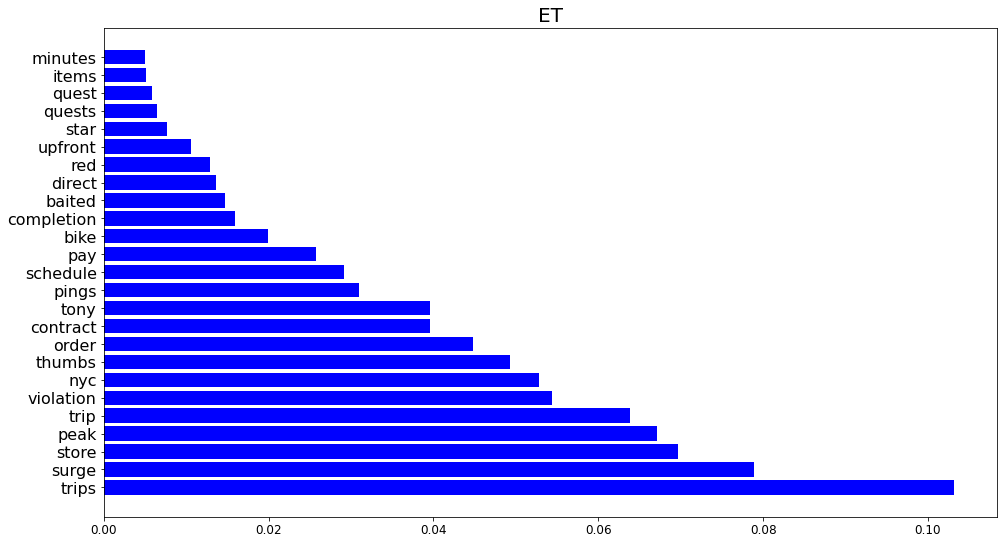

In [276]:
plt.figure(figsize=(16,9))
plt.barh(et_impt_25["Feature_Words"], et_impt_25["Importances"], color ='blue')
 
plt.title("ET", fontsize = 20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=16)

# Further exploration of data

### Based on the scores of best features and feature importances, we would like to get further insights in order to address our problem statement.

In [280]:
dd_head.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 10562
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  10000 non-null  object
 1   selftext   10000 non-null  object
 2   title      10000 non-null  object
 3   message    10000 non-null  object
dtypes: object(4)
memory usage: 390.6+ KB


In [282]:
df_dd = dd_head

In [346]:
df_ue = ue_head

In [284]:
df_dd.columns

Index(['subreddit', 'selftext', 'title', 'message'], dtype='object')

In [455]:
df_dd["message"].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# Red Card vs Plus Card

In [315]:
df_dd[df_dd["message"].str.contains("red card")].head(2)

,subreddit,selftext,title,message
215,doordash,"The gas pay. It is being included as doordash compensation. So, my bet is that if you would have received $100 of prop 22 pay, you will now receive $85 because the $15 of had money is being lumped into your compensation..... Meaning you are not actually getting it.\n\nSame issue with red card fails, so you end up using your own cc to pay for the order and getting reimbursed for it. Over the years, I have done this many times. Generally, it is no big deal. However a few weeks ago, I had to do it 2 times in the same day. 1 was refunded as an other pay, and the other was refunded as doordash pay.\n\nDoordash pay formulas are murky, but based on previous active hours and miles driven, I could tell that the reimbursement was factored in as doordash pay and it lowered my prop 22 top up. This means I was paid less (it also means that i paid for the order without being reimbursed.... Because they reimbursed me and then took it back out of the prop 22 top up) AND I will be taxed on my own money at the end of the year.\n\nNeedless to say, it has me quite angry. I have written and called multiple people with doordash..... And everyone of them has no clue what I am even saying. I get completely unrelated replies and answers. It is like swimming in molasses.\n\nSo, be very cautious of you pay for a red card order out of pocket.",For the Prop 22 people,"For the Prop 22 peopleThe gas pay. It is being included as doordash compensation. So, my bet is that if you would have received $100 of prop 22 pay, you will now receive $85 because the $15 of had money is being lumped into your compensation..... Meaning you are not actually getting it.\n\nSame issue with red card fails, so you end up using your own cc to pay for the order and getting reimbursed for it. Over the years, I have done this many times. Generally, it is no big deal. However a few weeks ago, I had to do it 2 times in the same day. 1 was refunded as an other pay, and the other was refunded as doordash pay.\n\nDoordash pay formulas are murky, but based on previous active hours and miles driven, I could tell that the reimbursement was factored in as doordash pay and it lowered my prop 22 top up. This means I was paid less (it also means that i paid for the order without being reimbursed.... Because they reimbursed me and then took it back out of the prop 22 top up) AND I will be taxed on my own money at the end of the year.\n\nNeedless to say, it has me quite angry. I have written and called multiple people with doordash..... And everyone of them has no clue what I am even saying. I get completely unrelated replies and answers. It is like swimming in molasses.\n\nSo, be very cautious of you pay for a red card order out of pocket."
295,doordash,I just did a Safeway order not the * shopping red card * one ..it's a Safeway order the dasher can just pick up the items from the Safeway employees ..it was a $260 79 item order\n\nI looked at the customer receipt it said EC drivers tip $35 ...\n\nBut I only got $8 dash pay ..this has never happen to me ..I always get the big tips on these type of big iSafeway order ..\n\nI was super excited when I saw $35 tip \n\nDid the employees steal my tip or did the customer take it away?,what happen to my $35 tip on my Safeway order,what happen to my $35 tip on my Safeway orderI just did a Safeway order not the * shopping red card * one ..it's a Safeway order the dasher can just pick up the items from the Safeway employees ..it was a $260 79 item order\n\nI looked at the customer receipt it said EC drivers tip $35 ...\n\nBut I only got $8 dash pay ..this has never happen to me ..I always get the big tips on these type of big iSafeway order ..\n\nI was super excited when I saw $35 tip \n\nDid the employees steal my tip or did the customer take it away?


In [351]:
df_dd[df_dd["message"].str.contains("red card")].shape

(75, 4)

There are at least 75 comments related to the red card. 

In [354]:
dd_red_card = df_dd[df_dd["message"].str.contains("red card")]

In [340]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [341]:
sent = SentimentIntensityAnalyzer()

In [342]:
def calculate_sentiment(text):
    # Run VADER on the text
    scores = sent.polarity_scores(text)
    # Extract the compound score
    compound_score = scores['compound']
    # Return compound score
    return compound_score

In [344]:
dd_red_card['sentiment'] = dd_red_card["message"].apply(calculate_sentiment)

<ipython-input-344-ea3176793076>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_red_card['sentiment'] = dd_red_card["message"].apply(calculate_sentiment)


In [345]:
dd_red_card['sentiment'].mean()

0.25330533333333327

There is generally a slight positive score amongst the users towards the Red Card.

In [350]:
df_ue[df_ue["message"].str.contains("plus card")].shape

(13, 4)

There are only about 13 comments related to the plus card.

In [353]:
ue_plus_card = df_ue[df_ue["message"].str.contains("plus card")]

In [355]:
ue_plus_card['sentiment'] = ue_plus_card["message"].apply(calculate_sentiment)

<ipython-input-355-f43c50d75e23>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ue_plus_card['sentiment'] = ue_plus_card["message"].apply(calculate_sentiment)


In [356]:
ue_plus_card['sentiment'].mean()

0.39123076923076916

These are cards used for payment by the drivers, with the bill credited to the company.

There seems to be a better sentiment towards our Plus Card compared to the Red Card. This has been the sentiments as seen on reddit threads generally. 

# "Tony" 

In [362]:
df_dd[df_dd["message"].str.contains("tony")].head(9)

,subreddit,selftext,title,message
355,doordash,"Its 11:00pm and im ready to head home for the night. I get a $4.00 offer from Pizza hut which I accepted only because I know this pizza hut closes at 10pm and its on the way home so fuck it ill get 2 bucks for cancelling it. Get to the pizza hut and sure enough, doors locked, lights off, they're closed up. So I mark it closed in the app and it doesn't even ask me to take a picture, just a quick confirm and im 2 bucks richer. As I walk back to my car the door opens and the employee goes ""For 'customer name""?"" and without hesitating I go ""yup' and they hand me the order and close the door. Checked the receipt and this dude ordered an hour and a half ago, which is weird because I thought DD would up the pay at that point, but guess not. It was still pretty good, and it felt good knowing that one cheap asshole gets to starve tonight. \n\n&amp;#x200B;\n\nto all the crybaby bootlickers who are gonna get personally offended on tonys behalf over this, I could care less, so save your strength for that Top Dasher grind and dont bother commenting",Got some free Pizza Hut thanks to a non tipper,"Got some free Pizza Hut thanks to a non tipperIts 11:00pm and im ready to head home for the night. I get a $4.00 offer from Pizza hut which I accepted only because I know this pizza hut closes at 10pm and its on the way home so fuck it ill get 2 bucks for cancelling it. Get to the pizza hut and sure enough, doors locked, lights off, they're closed up. So I mark it closed in the app and it doesn't even ask me to take a picture, just a quick confirm and im 2 bucks richer. As I walk back to my car the door opens and the employee goes ""For 'customer name""?"" and without hesitating I go ""yup' and they hand me the order and close the door. Checked the receipt and this dude ordered an hour and a half ago, which is weird because I thought DD would up the pay at that point, but guess not. It was still pretty good, and it felt good knowing that one cheap asshole gets to starve tonight. \n\n&amp;#x200B;\n\nto all the crybaby bootlickers who are gonna get personally offended on tonys behalf over this, I could care less, so save your strength for that Top Dasher grind and dont bother commenting"
456,doordash,,Saving soooo much ⛽️ Drove about 1300 miles this week for DD. Saved a whopping 1.1 cent per mile :))) Thanks tony 👎🏼,Saving soooo much ⛽️ Drove about 1300 miles this week for DD. Saved a whopping 1.1 cent per mile :))) Thanks tony 👎🏼
860,doordash,,"you're right, tony. I could be earning right now is Wendy's wasn't so slow","you're right, tony. I could be earning right now is Wendy's wasn't so slow"
861,doordash,,"you're right, tony. I could be earning right now if Wendy's wasn't slow as hell","you're right, tony. I could be earning right now if Wendy's wasn't slow as hell"
2815,doordash,"Idk If it's like this in your area. However in Mine, any type of place that sales ice cream, cakes, cookies etc always are no tips and all base pay. \n\nLike I did one that $8.50 for 5 miles. Took it because it put me in a area I was heading anyways. But when I get done I see it's all base pay lmao so fuck tony i guess. Every time I take a order for a place that sales desserts or sweets it's always base pay and 90% are double.\n\nIs it's just a Michigan thing?",What's up customers and Dessert places?,"What's up customers and Dessert places?Idk If it's like this in your area. However in Mine, any type of place that sales ice cream, cakes, cookies etc always are no tips and all base pay. \n\nLike I did one that $8.50 for 5 miles. Took it because it put me in a area I was heading anyways. But when I get done I see it's all base pay lmao so fuck tony i guess. Every time I take a order for a place that sales desserts or sweets it's always base pay and 90% are double.\n\nIs it's just a Michigan thing?"
4702,doordash,,Thank you Tony for your beautiful $2 orders all hail tony,Thank you Tony for your beautiful $2 orders all ha

In [357]:
df_dd[df_dd["message"].str.contains("tony")].shape

(9, 4)

There are only about 9 comments related to tony.

In [358]:
dd_tony = df_dd[df_dd["message"].str.contains("tony")]

In [359]:
dd_tony['sentiment'] = dd_tony["message"].apply(calculate_sentiment)

<ipython-input-359-3d0a885a0819>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_tony['sentiment'] = dd_tony["message"].apply(calculate_sentiment)


In [360]:
dd_tony['sentiment'].mean()

0.5210555555555555

But further analysis shows that it might not be the case. Some sentiments such as "Thank you Tony for your beautiful $2 orders all hail tony" are sarcasm, which are not picked up by our program. The emoji in sentences such as "Saving soooo much ⛽️ Drove about 1300 miles this week for DD. Saved a whopping 1.1 cent per mile :))) Thanks tony 👎🏼" might also not be picked up. 

# "Surge"

In [ ]:
This is found in the Uber Eats data set for MultiNomial NB, for both TVEC and CVEC.

In [363]:
df_ue[df_ue["message"].str.contains("surge")].head(9)

,subreddit,selftext,title,message
57,UberEATS,,Uber to return extra surge costs for riders during CTA outage; advocates say surge pricing rips off drivers,Uber to return extra surge costs for riders during CTA outage; advocates say surge pricing rips off drivers
63,UberEATS,Im not complaining but I have noticed many orders paying hefty surges that originally were half as much.\nWhy doesn't it show the surge price before accepting?\nOr is it that the surge happens after I accept?,Surge pay after accepting offer without surge,Surge pay after accepting offer without surgeIm not complaining but I have noticed many orders paying hefty surges that originally were half as much.\nWhy doesn't it show the surge price before accepting?\nOr is it that the surge happens after I accept?
96,UberEATS,"If your a noobie driver just getting started, here are a few tips that only come with time at the trade. \n\n1: it’s more economic to sit and wait than drive around. \n -since the job’s all about $/h, the act of driving means you are paying out of pocket to make the $ u recieve from working. When searching for that first delivery or on a dry spell, park in the middle of a shopping center parking lot and just wait (bring a book if u have to). At first, I was driving around restaurants and busy areas thinking I’d hedge my bets by spreading myself around, but instead just found I was using about 5$/h in gas just doing that to no actualy improvement of Dings frequencies. \n\n2: larger base fare aint always better.\n -I’ve heard and read that anything under 7$ isnt worth it. However, since tips make up roughly 50-75% of what you actually make, getting in more deliveries per hour increases tip amounts per hour. For instance, you could do about 2 deliveries of 8$ base fairs in an hour, but each one will get around 3-4$ average in tip; netting you 22-24$(not a bad hour). But, in that same hour, and with only 3$ base fair deliveries, you could do 4-5 deliveries in that hour, each with the same tip average; netting you 24-35$ (now that’s a moist hour right dhere!)\n\n3: darkness is better than sunshine\n -there’s a few advantages to delivering past the hour’s of 8 pm (if you don’t have a 7 year old’s bedtime) \n-Restaurants after 8pm tend to have less costomers and so are more ready to prepare your delivery quicker.\n-There are less cars on the road and so less traffic, making for quicker deliveries.\n-Parking lots and spaces are more empty for closer and more easy parking.\n-Many chain restaurants want you to use the drive through past 8 pm which can benefit drivers who don’t yet have a delivery bag\n-I’ve noticed that past 8, the ratio of those sweet “leave at door” instructions appear as people are more likely in their jamyjams. This makes it that you never have to waste time at someone’s door waiting for them to slowly shuffle their way from their bathtubs to you. \n\n4: oh god, not the 40th floor! \n -by staying away from inner cities and downtowns, you reduce the chances of having to go up elevators, talking to door security guys, and having to buzz into locked buildings. I’ve done 3 minutes at the buzzer, 4 minutes going up the elevator, 2 minutes walking down those god awful halls, 2 minutes back, 4 minutes down, and then 3 minute walk to my car parked far away cause the tall ones have underground private parking and are located on unparkable roads. Downtown has the best surges fo sho, but they also come with the most hellish of deliveries! Rich suburbs near shopping centers are la Uber crème. \n\n-Ghost mode\n - just a simple one, but I’ve found that if a costomer asks for “leave at door” and you are gone before they open their door, they usually give a “thumbs up” rating more often then if they saw me or interacted with me. Why? Idk, maybe I’m friteningly ugly. And so, after droping off the food, only post on the app that it’s been delivered once you are already in your car and about to leave, that way, costomer gets the ding that their food’s t

In [366]:
df_ue[df_ue["message"].str.contains("surge")].shape

(124, 4)

There are only about 124 comments related to surge.

In [367]:
ue_surge = df_ue[df_ue["message"].str.contains("surge")]

In [369]:
ue_surge['sentiment'] = ue_surge["message"].apply(calculate_sentiment)

<ipython-input-369-70fc926a84cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ue_surge['sentiment'] = ue_surge["message"].apply(calculate_sentiment)


In [370]:
ue_surge['sentiment'].mean()

0.07200967741935482

The score is mildly positive. 

# "Quest"

In [371]:
df_ue[df_ue["message"].str.contains("quest")].head(9)

,subreddit,selftext,title,message
2,UberEATS,,"Newb question. I accepted an offer for $12 3 miles away, but since Uber is hiding details I didn’t see where it was going. When I picked up food it said 14 miles so I left the food at the restaurant and called support, they made me cancel it but still got paid $9.53 Is the ban hammer coming ?","Newb question. I accepted an offer for $12 3 miles away, but since Uber is hiding details I didn’t see where it was going. When I picked up food it said 14 miles so I left the food at the restaurant and called support, they made me cancel it but still got paid $9.53 Is the ban hammer coming ?"
30,UberEATS,,"I got question. So i signed up as uber driver as bicycle but now i got Ebike, so since and changing from bike to ebike do i need to tell uber about it if yeah then how do i do it?","I got question. So i signed up as uber driver as bicycle but now i got Ebike, so since and changing from bike to ebike do i need to tell uber about it if yeah then how do i do it?"
45,UberEATS,"So I got an quest for 15 trips for ""up to 350 extra"", then of course it was only actually 250. I had only been doing uber eats and some Grubhub for about 9 months. I still decided to do it but so many things make it not worth it at all. The offers that come in only say the distance to pick up and minutes, how can I make a viable decision with only that information. Most of the trips I did were between 10-15 miles. Also literally nobody tips maybe 1 out 10 and even when they do it doesn't equate to my minimum of 2 dollars per mile. People also are not considerate, having to deal with drunk and entitled riders. I did ended up making about 750 in two days but only because of the quest. So I will just do uber eats and not deal with all those other factors.",uber x is the worst,"uber x is the worstSo I got an quest for 15 trips for ""up to 350 extra"", then of course it was only actually 250. I had only been doing uber eats and some Grubhub for about 9 months. I still decided to do it but so many things make it not worth it at all. The offers that come in only say the distance to pick up and minutes, how can I make a viable decision with only that information. Most of the trips I did were between 10-15 miles. Also literally nobody tips maybe 1 out 10 and even when they do it doesn't equate to my minimum of 2 dollars per mile. People also are not considerate, having to deal with drunk and entitled riders. I did ended up making about 750 in two days but only because of the quest. So I will just do uber eats and not deal with all those other factors."
56,UberEATS,"Hi. I am new to ubereats. I made an order yesterday for like $50 then tipped 18%. Everything went well. I then got a notification to rate the driver. So I rated him 5 stars and noticed a tip option on the bottom that said 18%. I thought nothing of it, thinking they are letting us raise or lower the original tip amount. But looking back at my receipts, it looks like I may have double tipped him? Was this the case?",Tip question from customer,"Tip question from customerHi. I am new to ubereats. I made an order yesterday for like $50 then tipped 18%. Everything went well. I then got a notification to rate the driver. So I rated him 5 stars and noticed a tip option on the bottom that said 18%. I thought nothing of it, thinking they are letting us raise or lower the original tip amount. But looking back at my receipts, it looks like I may have double tipped him? Was this the case?"
118,UberEATS,I delivered a large order last week that was requested by a restaurant and not directly ordered through Uber Eats. I have delivered from this restaurant before in the same fashion and have never had an issue. Initially they customer service chat told me what the total payout for the delivery was. They are now telling me that the trip was unauthorized and there are no rider payments or earnings associated with it. Has anyone else had this issue and managed to get payed for it. So 

In [381]:
import re

In [404]:
dataframe = []
for i in df_ue["message"]:
    x = tokenizer.tokenize(i)
    for a in x:
        if a == "quest":
            dataframe.append(i)
        elif i == "quest.":
            dataframe.append(i)

 

In [405]:
dataframe

['uber x is the worstSo I got an quest for 15 trips for  "up to 350 extra", then of course it was only actually 250. I had only been doing uber eats and some Grubhub for about 9 months. I still decided to do it but so many things make it not worth it at all. The offers that come in only say the distance to pick up and minutes, how can I make a viable decision with only that information. Most of the trips I did were between 10-15 miles. Also literally nobody tips maybe 1 out 10 and even when they do it doesn\'t equate to my minimum of 2 dollars per mile. People also are not considerate, having to deal with drunk and entitled riders. I did ended up making about 750 in two days but only because of the quest. So I will just do uber eats and not deal with all those other factors.',
 'uber x is the worstSo I got an quest for 15 trips for  "up to 350 extra", then of course it was only actually 250. I had only been doing uber eats and some Grubhub for about 9 months. I still decided to do it b

In [411]:
quest_pd = pd.DataFrame(dataframe, columns = ['message'])

In [412]:
quest_pd

,message
0,"uber x is the worstSo I got an quest for 15 trips for ""up to 350 extra"", then of course it was only actually 250. I had only been doing uber eats and some Grubhub for about 9 months. I still decided to do it but so many things make it not worth it at all. The offers that come in only say the distance to pick up and minutes, how can I make a viable decision with only that information. Most of the trips I did were between 10-15 miles. Also literally nobody tips maybe 1 out 10 and even when they do it doesn't equate to my minimum of 2 dollars per mile. People also are not considerate, having to deal with drunk and entitled riders. I did ended up making about 750 in two days but only because of the quest. So I will just do uber eats and not deal with all those other factors."
1,"uber x is the worstSo I got an quest for 15 trips for ""up to 350 extra"", then of course it was only actually 250. I had only been doing uber eats and some Grubhub for about 9 months. I still decided to do it but so many things make it not worth it at all. The offers that come in only say the distance to pick up and minutes, how can I make a viable decision with only that information. Most of the trips I did were between 10-15 miles. Also literally nobody tips maybe 1 out 10 and even when they do it doesn't equate to my minimum of 2 dollars per mile. People also are not considerate, having to deal with drunk and entitled riders. I did ended up making about 750 in two days but only because of the quest. So I will just do uber eats and not deal with all those other factors."
2,"Have you completed a quest and not received the bonus?The quest was, “Complete 1 more deliveries to receive $10 and unlock another quest”. I drove specifically to the main part of the city specified in the requirements and now Uber Support is pushing back and saying I didn’t meet the requirements. This has me reassessing driving for Uber."
3,"Have you completed a quest and not received the bonus?The quest was, “Complete 1 more deliveries to receive $10 and unlock another quest”. I drove specifically to the main part of the city specified in the requirements and now Uber Support is pushing back and saying I didn’t meet the requirements. This has me reassessing driving for Uber."
4,"Have you completed a quest and not received the bonus?The quest was, “Complete 1 more deliveries to receive $10 and unlock another quest”. I drove specifically to the main part of the city specified in the requirements and now Uber Support is pushing back and saying I didn’t meet the requirements. This has me reassessing driving for Uber."
...,...
72,"How do I not care?I just a got another thumbs down. Second one today. \n\nThis guy changed his address, which cost me my quest because I added his order on since it was at the same apartment. He ended up at a house. I handed it off to him, with a real attitude he says “thank you” and I say real quietly, because not only am I very mad, and very tired after going since 11, “you’re welcome”. \n\nLike what the fuck was I supposed to do? Roll out the magic carpet after you cost me my last part of my quest? I’m so sick of these people. Maybe I could have been nicer or whatever, but still. Now im at 93 percent. \n\nSo how do I not care so much when it’s all I know? I care about people being happy with their service, doing a good job. It’s how I’ve always been, whether I was a janitor or a Fulfillment Team Lead. This shit is really starting to get to me. I don’t want people to see I have 7 thumbs downs and think I don’t care or I don’t deserve a tip."
73,"How do I not care?I just a got another thumbs down. Second one today. \n\nThis guy changed his address, which cost me my quest because I added his order on since it was at the same apartment. He ended up at a house. I handed it off to him, with a real attitude he says “thank you” and I say real quietly, because not only am I very mad, and very tired after going since 11, “you’re welcome”. \n\nLike what 

In [413]:
quest_pd['sentiment'] = quest_pd["message"].apply(calculate_sentiment)

In [415]:
quest_pd['sentiment'].mean()

0.1415831168831169

General positive sentiment to our quest service.

# The word "minutes" appear quite often in both sets

This is found also in  both data sets for Random Forests

#### For Datadash

In [416]:
df_dd[df_dd["message"].str.contains("minutes")].head(9)

,subreddit,selftext,title,message
15,doordash,,All in favor of petitioning to DoorDash about rating customers?? Don’t threaten me without even leaving a tip 🤣 spent 30 to 45 minutes shopping for your stuff while you get to sit in the comfort of your own home and don’t even bother to tip… smh.,All in favor of petitioning to DoorDash about rating customers?? Don’t threaten me without even leaving a tip 🤣 spent 30 to 45 minutes shopping for your stuff while you get to sit in the comfort of your own home and don’t even bother to tip… smh.
24,doordash,"Why does the app freeze constantly when I near restaurants, so that it can take up to five minutes to mark arrive...sometimes I can't and have to drive away half a mile before able to do so. \n\nAND directions don't open for a good mile. I can't work like this. It has been like this all week\n\nAnybody know what's going on?",the APP from hell!,"the APP from hell!Why does the app freeze constantly when I near restaurants, so that it can take up to five minutes to mark arrive...sometimes I can't and have to drive away half a mile before able to do so. \n\nAND directions don't open for a good mile. I can't work like this. It has been like this all week\n\nAnybody know what's going on?"
38,doordash,,I got this 5 minutes after I dropped it off. Did she cancel her order?,I got this 5 minutes after I dropped it off. Did she cancel her order?
59,doordash,After tipping 20$ then proceed to drop off 3 other orders before mine while letting my food cool for an hour and half best believe I’m contacting support changing ur tip to zero and giving you the worst review of your live 🤣🤣🤣🤣,Bruh stop waiting for 20-30 minutes in the parking lot waiting for other peoples orders.,Bruh stop waiting for 20-30 minutes in the parking lot waiting for other peoples orders.After tipping 20$ then proceed to drop off 3 other orders before mine while letting my food cool for an hour and half best believe I’m contacting support changing ur tip to zero and giving you the worst review of your live 🤣🤣🤣🤣
61,doordash,"I'm still relatively new but I had a confusing delivery. \n\nI had a delivery. Got to the restaurant 3 minutes late due to traffic but the food was ready and bagged so they handed it to me and I took it to the customers house. I double checked the house number, street name, Google maps, and the doordash map. All of it lined up. The app said hand it to customer so I rang the doorbell and waited. No one answered. I clicked on can't find customer and it said to try to contact them and gave me a five minute timer. I texted them and waited the five minutes. No response. Rang the doorbell one more time and waited another minute while dogs inside the house barked at me through the glass door. Underneath the timer it said that if I can't find the customer to return the order to the restaurant and had a button for return order. I clicked on return the order and the app jumped right to the dash paused screen. Confused I called support and they were a little confusing but I got the impression that the order was cancelled? The support agent asked me to unpause my dash and see if I had been paid for the order so I did and I had been. They said to go about my business and at first I was going to continue my dash but I changed my mind and paused my dash again to go home. When I got home I got a text from the customer to leave the order at the door. This was about 25 minutes after I had initially texted. So I called dasher support again and they said the order had been abandoned but that it was documented that I had called them. I could either try returning the order to the restaurant or continue dashing but the order was done. I ended my dash and just took the order back to the restaurant. No one really had a clue what to do so they got the manager. The manager seemed confused and told me he has never had someone return the food before but thank you and that was it. I left and the restaurant had the order again. I called d

In [417]:
dd_minutes = df_dd[df_dd["message"].str.contains("minutes")]

In [418]:
dd_minutes['sentiment'] = dd_minutes["message"].apply(calculate_sentiment)

<ipython-input-418-db7bbc86e3a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_minutes['sentiment'] = dd_minutes["message"].apply(calculate_sentiment)


In [419]:
dd_minutes['sentiment'].mean()

-0.04267518684603883

The score is mildly negative for datadash.

#### For Uber Eats

In [420]:
df_ue[df_ue["message"].str.contains("minutes")].head(9)

,subreddit,selftext,title,message
8,UberEATS,"Hi All, \n\nI'm just wondering if anyone on here has experienced an unpleasant or just down right rude incident with someone making a delivery? \n\nI just had an incident tonight where a guy was delivering food to a unit in my condo building. You need a fob in order to get in the front door so the guy was just standing there waiting. Mind you the food was not for me, I didn't order anything but to someone else that lives in my building. Once I clicked the door open he pushed through me. The door is barely fucking open, I am trying to get out and he is trying to come in at the same time. Pushed me against the door frame (so I was fucking stuck) and stepped on my dog so he could get in. No apologies, nothing. Didn't give a fuck. I yelled at him asking him WTF is his problem and all he said was ""It was an accident"" then went in the elevator and disappeared.\n\nI called Uber Eats, spent 30 minutes on the phone with them just for them to ask me repeatedly what happened and tell me they'll forward the incident to another team. I asked them to find the guy by what deliveries have been made to my building address around 11:15pm tonight and they said they don't know if they can do that??? I find that to be a load of shit.\n\nBasically I wanted to know if anyone here has had a bad experience with an Uber eats delivery person and if you made a complaint. If so, what came of it? Do you think they'd even really do anything?\n\nOr maybe you work for them and had someone make a complaint, does Uber as a company, actually do anything?",Does Uber Eats actually do anything when there are complaints about delivery drivers?,"Does Uber Eats actually do anything when there are complaints about delivery drivers?Hi All, \n\nI'm just wondering if anyone on here has experienced an unpleasant or just down right rude incident with someone making a delivery? \n\nI just had an incident tonight where a guy was delivering food to a unit in my condo building. You need a fob in order to get in the front door so the guy was just standing there waiting. Mind you the food was not for me, I didn't order anything but to someone else that lives in my building. Once I clicked the door open he pushed through me. The door is barely fucking open, I am trying to get out and he is trying to come in at the same time. Pushed me against the door frame (so I was fucking stuck) and stepped on my dog so he could get in. No apologies, nothing. Didn't give a fuck. I yelled at him asking him WTF is his problem and all he said was ""It was an accident"" then went in the elevator and disappeared.\n\nI called Uber Eats, spent 30 minutes on the phone with them just for them to ask me repeatedly what happened and tell me they'll forward the incident to another team. I asked them to find the guy by what deliveries have been made to my building address around 11:15pm tonight and they said they don't know if they can do that??? I find that to be a load of shit.\n\nBasically I wanted to know if anyone here has had a bad experience with an Uber eats delivery person and if you made a complaint. If so, what came of it? Do you think they'd even really do anything?\n\nOr maybe you work for them and had someone make a complaint, does Uber as a company, actually do anything?"
32,UberEATS,,"why is everything too far to deliver? i only live like 10 minutes away from town, any way to get around this?","why is everything too far to deliver? i only live like 10 minutes away from town, any way to get around this?"
42,UberEATS,"In New Hampshire, they’re doing a promotion where you’re guaranteed $20 an hour(before tips) from 5-9pm as long as you accept 75% of deliveries. Great. \n\nExcept this week, the app has been constantly crashing on me, I show up to deliveries that are already picked up, or I’m told insane wait times by restaurants. \n\nI accepted a delivery about 20 minutes ago, and when I showed up to the restaurant they told me their system was bei

In [421]:
ue_minutes = df_ue[df_ue["message"].str.contains("minutes")]

In [422]:
ue_minutes['sentiment'] = ue_minutes["message"].apply(calculate_sentiment)

<ipython-input-422-d64d92d5b4a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ue_minutes['sentiment'] = ue_minutes["message"].apply(calculate_sentiment)


In [423]:
ue_minutes['sentiment'].mean()

-0.0017127853881278676

The score is mildly negative, but not as much as DoorDash's. Could be similar in that people generally would not like to wait for so long for picking up orders or receiving orders.

## "good" appearing in our (Uber Eats) dataset

In [424]:
df_ue[df_ue["message"].str.contains("good")].head(9)

,subreddit,selftext,title,message
18,UberEATS,Currently on hold with support because I’m an idiot and took a Popeyes order…but I heard their rooster in the background 😂😂😂 that’s all have a good night y’all!,Uber support,Uber supportCurrently on hold with support because I’m an idiot and took a Popeyes order…but I heard their rooster in the background 😂😂😂 that’s all have a good night y’all!
51,UberEATS,"i dont care about wether its effective for hypertrophy or not-i have prom tonight and i want to get a skin-tearing pump especially chest, triceps and delts. anyone know any good pump-training routines?",workout thats good for an upper body pump and nothing else?,"workout thats good for an upper body pump and nothing else?i dont care about wether its effective for hypertrophy or not-i have prom tonight and i want to get a skin-tearing pump especially chest, triceps and delts. anyone know any good pump-training routines?"
58,UberEATS,I'm 30 and this is the first accident I've ever had. I wasn't delivering. My car was totalled but the guy I hit barely had a scratch. Insurance says I'm at fault but I'm in a no fault state. No citation was given. Am I good or...? I'm just worried about the background checks. I deliver for doordash as well.,Got into an accident will I be deactivated?,Got into an accident will I be deactivated?I'm 30 and this is the first accident I've ever had. I wasn't delivering. My car was totalled but the guy I hit barely had a scratch. Insurance says I'm at fault but I'm in a no fault state. No citation was given. Am I good or...? I'm just worried about the background checks. I deliver for doordash as well.
67,UberEATS,,Is the giant insulated backpack bag worth it for bicycle delivery? I know it’s $50 but I haven’t found a good alternative,Is the giant insulated backpack bag worth it for bicycle delivery? I know it’s $50 but I haven’t found a good alternative
76,UberEATS,,"I never ever tip Uber eats food. It’s stupid, I’m already paying fees and my $10 meal just turned into a $22 meal why would I turn that into $25? Tipping is not necessary and I’ve always received good service without tipping. It’s just a scam.","I never ever tip Uber eats food. It’s stupid, I’m already paying fees and my $10 meal just turned into a $22 meal why would I turn that into $25? Tipping is not necessary and I’ve always received good service without tipping. It’s just a scam."
80,UberEATS,"So i just did my first shift of two and an half hours and im exausted.\n\nIve done 5 trips, 2 of them with some very high mountains, they werent very far, 2 or 3 km, but left me broken eheh.\n\nI think im in a good shape and ive always trained, yet, very high praise to all of you who deliver all day with a bike, now excuse me, im gonna put my legs in some ice!","deliveries with a Bicycle, impossible?","deliveries with a Bicycle, impossible?So i just did my first shift of two and an half hours and im exausted.\n\nIve done 5 trips, 2 of them with some very high mountains, they werent very far, 2 or 3 km, but left me broken eheh.\n\nI think im in a good shape and ive always trained, yet, very high praise to all of you who deliver all day with a bike, now excuse me, im gonna put my legs in some ice!"
96,UberEATS,"If your a noobie driver just getting started, here are a few tips that only come with time at the trade. \n\n1: it’s more economic to sit and wait than drive around. \n -since the job’s all about $/h, the act of driving means you are paying out of pocket to make the $ u recieve from working. When searching for that first delivery or on a dry spell, park in the middle of a shopping center parking lot and just wait (bring a book if u have to). At first, I was driving around restaurants and busy areas thinking I’d hedge my bets by spreading myself around, but instead just found I was using about 5$/h in gas just doing that to no actualy improvement of Dings frequencies. \n\n2: larger base fare aint always better.\n -I’ve heard and read that anythin

In [425]:
ue_good = df_ue[df_ue["message"].str.contains("good")]

In [431]:
ue_good['sentiment'] = ue_good["message"].apply(calculate_sentiment)

<ipython-input-431-f146da995726>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ue_good['sentiment'] = ue_good["message"].apply(calculate_sentiment)


In [432]:
ue_good['sentiment'].mean()

0.40922573529411854

There seems to be some positive energy, such as "I've received good service", "I'm in good shape" etc as seen from the texts.

# Conclusion

Our best model for accuracy would be that of the Multinomial NB, TVEC. This model improved our score from the baseline of 65.0% to 69.6%.

For our inquiry into brand differentiation using the best features/ estimators from our various models, main words that differentiate us from DoorDash seems to be "Plus Card" and "Quests", which seems like good anchors. We might consider another word that might be seasonal- "surge"s seem to be a good trend which our drivers enjoy.

For our enquiry into the general sentiments towards the two companies, both of us share the communities' concern towards time-related words, while our community can be differentiated from DoorDash's by the word "good". We will take note of this positive trend.

# Further steps / Recommendations

We can do more textual analysis on the texts containing these differentiating words, on top of the VADER sentiment scoring. These could be for instance into messages containing the word "good", which is important for us as a team to glean insights. Some of these VADER scores might not be the best too, as it could be a pot of insights which are generally good, but we cannot ignore the possibility of bad reviews.



The Words that are of importance in this time frame of  03 Oct 2021 to 26 March 2022:
We will have to continuously measure these data to update our knowledge of our drivers and users, and our branding
